<a href="https://colab.research.google.com/github/LorenaMueller/refine_DCG_outlines/blob/master/code/b_colab_analysis/snipplet_RF_all_glaciers_SGI2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forest Classification to refine DCG outlines
---
---
This script aims to outline debris-covered glaciers (DCGs) in a most simple and automated way. The relevant input data is preprocessed in Google Earth Engine and exported to a drive folder. This script accesses the same folder, loads the relevant data and runs a random forest classification. The results are mapped and statistically evaluated.
Test and training glaciers are defined in "2. Load Data" (make sure to exclude the test glacier from the training glaciers).

# Content
---
1. Import Libraries
2. Load Data
3. Extract Neighbors Function
4. Train and Apply Random Forest Classifier (not included. Use the complete script, if needed: 'complete_RF_all_glaciers.ipynb')
5. Permutation Importance (not included)
6. Probability Maps
7. Thresholding, statistical evaluation and visualisation
8. Clean up binary classification results (optional)
9. Generate consensus glacier polygons (2016-2024)
10. Vectorize and store results
11. Plot DCG outlines of different years
12. Polygon-based evaluation against SGI2016
13. Compare Permutation Importance values

---
This script can be used only if no changes are made to the input data and setup of the classifier (access the provided "ensemble_results" here: https://drive.google.com/drive/folders/1y7jBnQ6PUZxdVV6GRvbdyzUl_xE3tR7P?usp=sharing). If a complete analysis is needed, use this script: 'complete_RF_all_glaciers.ipynb'.

1. Import Libraries

In [125]:
# Earth Engine and OS
import ee  # Google Earth Engine API
import os  # OS-level operations

# Numerical and Data Handling
import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation
import random  # Random operations
from collections import defaultdict  # Handling nested dictionaries

# Raster and Vector Processing
import rasterio  # Raster data reading and writing
from rasterio.mask import mask  # Masking rasters using vector geometries
from osgeo import gdal  # Geospatial Data Abstraction Library (raster handling)

# Image Processing and Filtering
from scipy.ndimage import gaussian_filter, label  # For smoothing and labeling
from skimage import measure  # Region-based measurements

# Machine Learning
from sklearn.ensemble import RandomForestClassifier  # Random Forest model
from sklearn.model_selection import StratifiedShuffleSplit  # Stratified train-test splitting
from sklearn.utils import resample  # Bootstrap resampling
from sklearn.metrics import accuracy_score, classification_report  # Model evaluation metrics
from sklearn.inspection import permutation_importance  # Feature importance

# XGBoost (optional use)
from xgboost import XGBClassifier  # XGBoost model

# Geospatial Vector Data
import geopandas as gpd  # Handling vector data (shapefiles etc.)
from shapely.geometry import Polygon, MultiPolygon, shape, mapping  # Geometries
from shapely.ops import unary_union  # Merge geometries
import fiona  # Read/write geospatial data formats

# Visualization
import matplotlib.pyplot as plt  # Plotting
from matplotlib.patches import Patch  # Custom legends
import seaborn as sns  # Advanced plotting


2. Load Data
---
This section prepares the training and testing datasets by selecting glaciers and years, mounting Google Drive, loading raster and label data, clipping rasters using glacier buffers, and mapping selected bands. The steps include:
- Selecting the training and testing configuration
- Mounting Google Drive for data access
- Dynamically loading and clipping glacier image and label rasters
- Defining which bands will be used for model training and testing

In [126]:
# 2.1 Select training/test configuration
train_year = 2016  # Always using 2016 for training
train_glaciers = ['unteraar', 'mauvoisin', 'zmutt', 'oberaletsch']  # Glaciers used for training
test_glacier = 'zinal'  # Glacier to test on (must be excluded from training)
test_year = [2016, 2018, 2020, 2022, 2024]  # Years to test on

# 2.2 Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2.3 Define glaciers and years used in analysis
glaciers = ['zmutt', 'unteraar', 'belvedere', 'oberaletsch', 'zinal', 'mauvoisin', 'satopanth']
years = [2016, 2018, 2020, 2022, 2024]

# 2.4 Generate paths to input images per glacier and year
image_paths = {}
for glacier in glaciers:
    image_paths[glacier] = {}
    for year in years:
        image_paths[glacier][year] = f"/content/drive/My Drive/GEE_Exports_input_layers_DCG/{glacier}_{year}_layers_drive.tif"

# 2.5 Function to read a raster using GDAL
def read_raster(image_path):
    dataset = gdal.Open(image_path, gdal.GA_ReadOnly)
    if dataset is None:
        raise ValueError(f"Failed to open {image_path}. Check if the file exists and is readable.")
    image_array = dataset.ReadAsArray()
    return np.array(image_array)  # Ensure NumPy format

# 2.6 Load all image data
original_image_data = {}
for glacier in glaciers:
    original_image_data[glacier] = {}
    for year in years:
        original_image_data[glacier][year] = read_raster(image_paths[glacier][year])

# 2.7 Paths to ground truth labels
labels_path = {
    "zmutt": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/zmutt_labels.tif",
    "unteraar": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/unteraar_labels.tif",
    "belvedere": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/belvedere_labels.tif",
    "oberaletsch": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/oberaletsch_labels.tif",
    "zinal": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/zinal_labels.tif",
    "mauvoisin": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/mauvoisin_labels.tif",
    "satopanth": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/satopanth_labels.tif"
}

# 2.8 Load label rasters (assumed to be single-band)
original_label_data = {}
for key, path in labels_path.items():
    with rasterio.open(path) as src:
        original_label_data[key] = src.read(1)

# 2.9 Define paths to glacier buffer shapefiles
buffers_paths = {
    "zmutt": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/rgi_buffer_zmutt.shp",
    "unteraar": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/rgi_buffer_unteraar.shp",
    "oberaletsch": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/rgi_buffer_oberaletsch.shp",
    "belvedere": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/rgi_buffer_belvedere.shp",
    "zinal": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/rgi_buffer_zinal.shp",
    "mauvoisin": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/rgi_buffer_mauvoisin.shp",
    "satopanth": "/content/drive/My Drive/GEE_Exports_input_layers_DCG/rgi_buffer_satopanth.shp"
}

# 2.10 Load buffer shapefiles
buffers = {key: gpd.read_file(path) for key, path in buffers_paths.items()}

# 2.11 Function to clip raster with buffer geometry
def clip_raster(raster_array, raster_path, buffer_gdf):
    with rasterio.open(raster_path) as src:
        buffer_gdf = buffer_gdf.to_crs(src.crs)  # Reproject to raster CRS
        geometries = [geom for geom in buffer_gdf.geometry]

        # Clip and mask raster
        clipped_image, clipped_transform = mask(src, geometries, crop=True, filled=False)

        # Convert masked values to NaNs
        clipped_image = clipped_image.astype('float32')
        clipped_image = np.where(clipped_image.mask, np.nan, clipped_image.data)

        # Reorder bands if needed
        if clipped_image.ndim == 3:
            clipped_image = np.moveaxis(clipped_image, 0, -1)

        clipped_meta = src.meta.copy()
        clipped_meta.update({
            "height": clipped_image.shape[0],
            "width": clipped_image.shape[1],
            "transform": clipped_transform
        })
    return clipped_image, clipped_meta

# 2.12 Function to create adaptive buffer (not used in main flow but available)
def create_adaptive_buffer(rgi_gdf, dem_path, low_percentile=10, front_buffer=300, side_buffer=100):
    with rasterio.open(dem_path) as src:
        dem_crs = src.crs
        rgi_gdf = rgi_gdf.to_crs(dem_crs)
        geometries = [geom for geom in rgi_gdf.geometry]
        dem_clip, _ = mask(src, geometries, crop=True)
        dem_data = dem_clip[0]
        dem_data = np.where(dem_data == src.nodata, np.nan, dem_data)

        valid_elevs = dem_data[~np.isnan(dem_data)]
        if valid_elevs.size == 0:
            print("No valid elevation data inside glacier polygon.")
            return None

        threshold = np.percentile(valid_elevs, low_percentile)
        low_area_mask = (dem_data <= threshold).astype(np.uint8)

        shapes_low = list(measure.find_contours(low_area_mask, 0.5))
        low_polygons = []
        for contour in shapes_low:
            coords = [(int(x[1]), int(x[0])) for x in contour]
            poly = Polygon(coords)
            if poly.is_valid:
                low_polygons.append(poly)

        original_poly = unary_union(rgi_gdf.geometry)
        low_area_union = unary_union(low_polygons)
        buffer_front = low_area_union.buffer(front_buffer)
        buffer_rest = original_poly.difference(low_area_union).buffer(side_buffer)
        final_buffer = unary_union([buffer_front, buffer_rest])

        return gpd.GeoDataFrame(geometry=[final_buffer], crs=dem_crs)

# 2.13 Clip label rasters with corresponding glacier buffers
image_data = {}
label_data = {}
for glacier in glaciers:
    image_data[glacier] = {}
    label_data[glacier], _ = clip_raster(original_label_data[glacier], labels_path[glacier], buffers[glacier])

# 2.14 Clip all images using buffer polygons
for glacier in glaciers:
    for year in years:
        image_data[glacier][year], image_meta = clip_raster(
            original_image_data[glacier][year],
            image_paths[glacier][year],
            buffers[glacier]
        )
        # Save metadata for test glacier and years
        if glacier == test_glacier and year in test_year:
            binary_meta = image_meta

# 2.15 Define bands to use for model training/testing
selected_bands = [
    'lstNir', 'lstNir_superPixelMeans', 'edges', 'smooth',
    'ndwi', 'ndsi', 'ndvi', 'slope', 'aspect', 'elevation',
    'gradient', 'TPI', 'glacierInventory', 'inSAR',
    'normalizedLst', 'coherence', 'VH'
]
bands = selected_bands

# 2.16 Map selected band names to band indices (subset shown)
band_indices = {
    # Example subset mapping; update as needed
    'lstNir_superPixelMeans': 2,
    'ndwi': 5,
    'ndsi': 6,
    'ndvi': 7,
    'slope': 8,
    'normalizedLst': 15,
    'coherence': 16,
    'VH': 17
}


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


3. Extract-neighbours-function
---
This function extracts the values of the center pixel and its 4 immediate neighbors (top, bottom, left, right) for each selected band. These features are used to enhance the spatial context during Random Forest classification. Only pixels with valid (non-NaN) labels are included. The image array is padded using reflective padding to ensure that border pixels are included.

In [127]:
def extract_with_neighbors(image_array, label_array, selected_bands, band_indices):
    """
    Extract pixel values and their 4 neighbors for selected bands, flatten to table format.
    Includes **all** pixels by padding the edges (mode='reflect').
    Only includes pixels with valid (non-NaN) labels.
    """
    # Pad top/bottom by 1, left/right by 1, leave band axis unchanged
    padded = np.pad(image_array, ((1, 1), (1, 1), (0, 0)), mode="reflect")

    h, w, _ = image_array.shape
    data_list = []

    # Loop over original pixel coordinates
    for y in range(h):
        for x in range(w):
            label = label_array[y, x]
            if np.isnan(label):
                continue

            feature_dict = {"label": label.item() if isinstance(label, np.ndarray) else int(label)}

            for band in selected_bands:
                if band not in band_indices:
                    continue
                idx = band_indices[band]

                # center is at padded[y+1, x+1]
                yc, xc = y + 1, x + 1
                feature_dict[f"{band}_center"] = padded[yc,   xc,   idx]
                feature_dict[f"{band}_top"]    = padded[yc-1, xc,   idx]
                feature_dict[f"{band}_bottom"] = padded[yc+1, xc,   idx]
                feature_dict[f"{band}_left"]   = padded[yc,   xc-1, idx]
                feature_dict[f"{band}_right"]  = padded[yc,   xc+1, idx]

            data_list.append(feature_dict)

    return pd.DataFrame(data_list)


4. Apply Random Forest classifier
---
In this section, the training and testing data is prepared and the Random Forest classifier (RF) is applied, using XGBoost. The best parameter combination across all 5 swiss glaciers was achieved using optuna (seperate script, using anaconda, spyder).The RF loops over 20 different band combinations that consist of the 35 input layers (7 base layers x 5 pixels). The classification is done for each of the test years and the results are stored for further analysis and visualisation.

5. Visualize Permutation Importance
---
In this section, the permutation importance is visualized in boxplots. The importance is visualized per year and for each of the 7 base layers.
Consider these plots with caution, since the permutation importance is averaged across multiple band combinations and for the neighbouring pixels. To make statements about actual importance, the results of each band combination should be evaluated.

6. Probability Maps
---
The probability scores were stored during the XGBoost classification runs and are visualized here for each glacier and year. This section displays side-by-side plots of the predicted probability map and the ensemble classification result normalized to the range [0, 1]. The ensemble result represents the fraction of votes from multiple classifiers, providing additional insight into classification consensus alongside the probability scores.

In [128]:
import matplotlib.pyplot as plt
import rasterio
import glob
import os

# Inputs
probability_folder = "/content/drive/MyDrive/probability_scores_rf"
ensemble_folder = "/content/drive/MyDrive/ensemble_results"

for year in test_year:
    prob_path = os.path.join(probability_folder, f"{test_glacier}_{year}_probability_map.tif")
    ensemble_path = os.path.join(ensemble_folder, f"{test_glacier}_{year}_ensemble_result.tif")

    if not os.path.exists(prob_path) or not os.path.exists(ensemble_path):
        print(f"Missing files for {test_glacier} {year}")
        continue

    with rasterio.open(prob_path) as src:
        prob_data = src.read(1)

    with rasterio.open(ensemble_path) as src:
        ensemble_data = src.read(1).astype(np.float32)

    # Normalize ensemble result to [0, 1]
    ensemble_normalized = ensemble_data / 20.0

    # Plot side-by-side
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    im1 = axs[0].imshow(prob_data, cmap='viridis', vmin=0, vmax=1)
    axs[0].set_title(f"Probability Map: {test_glacier.capitalize()} {year}")
    axs[0].axis("off")
    fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04, label='Probability')

    im2 = axs[1].imshow(ensemble_normalized, cmap='viridis', vmin=0, vmax=1)
    axs[1].set_title(f"Ensemble Votes (Normalized): {test_glacier.capitalize()} {year}")
    axs[1].axis("off")
    fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04, label='Vote Fraction')

    plt.tight_layout()
    plt.show()


Missing files for zinal 2016
Missing files for zinal 2018
Missing files for zinal 2020
Missing files for zinal 2022
Missing files for zinal 2024


7. Thresholding, statistical evaluation and visualisation
---
This section calculates and applies a threshold to the accumulated classification results (ensemble sum image) using focused Otsu thresholding with background estimation. It then smooths the binary classification result, evaluates performance metrics against the SGI2016 reference (precision, recall, F1-score, accuracy), and visualizes both intermediate and final classification results with overlays of ground truth contours, scale bars, and north arrows.

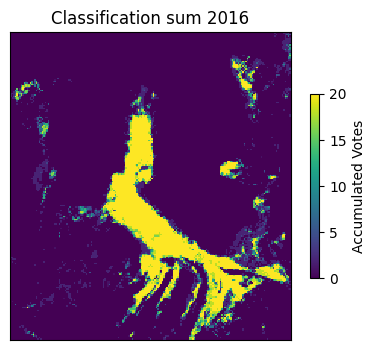

Threshold used (Otsu): 12.00


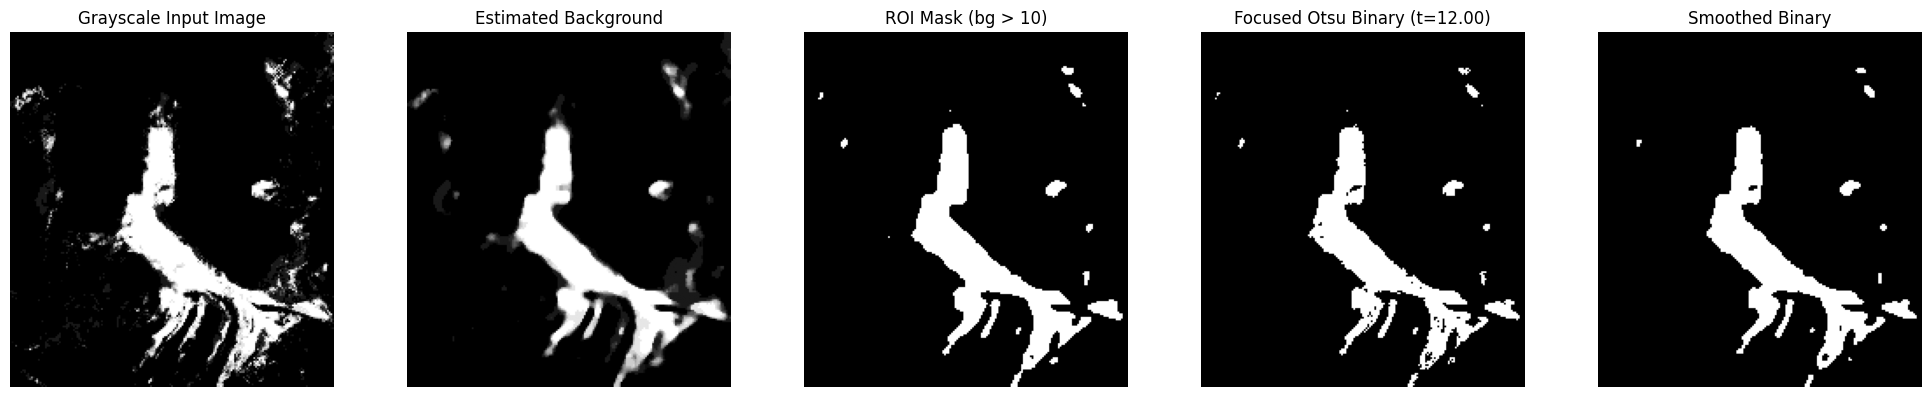

Final Accuracy (after thresholding and smoothing) 2016: 0.9231
Classification Report for final result 2016:
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95     17588
         1.0       0.85      0.73      0.79      4217

    accuracy                           0.92     21805
   macro avg       0.89      0.85      0.87     21805
weighted avg       0.92      0.92      0.92     21805



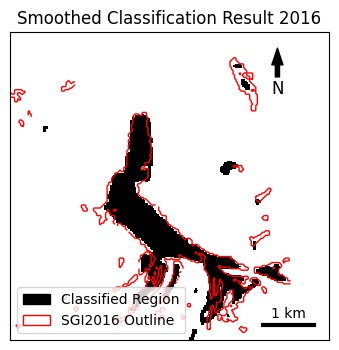


==== Summary for Year: 2016 ====
Accuracy: 0.9231
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95     17588
         1.0       0.85      0.73      0.79      4217

    accuracy                           0.92     21805
   macro avg       0.89      0.85      0.87     21805
weighted avg       0.92      0.92      0.92     21805



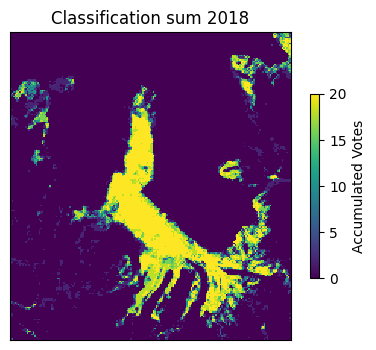

Threshold used (Otsu): 12.00


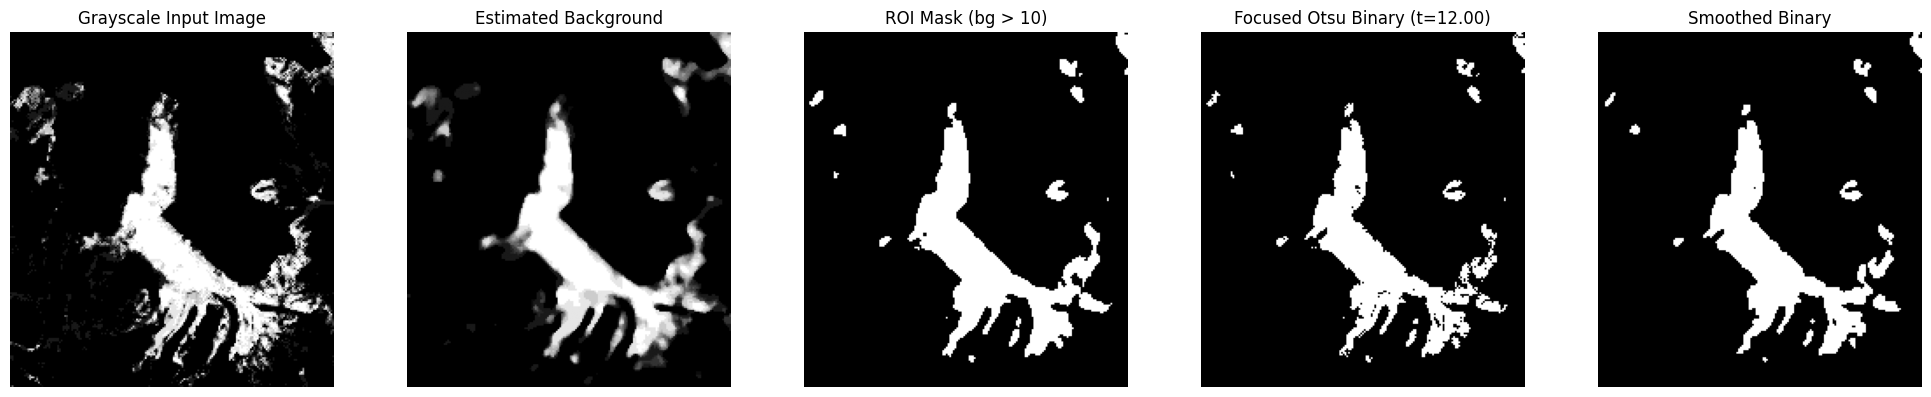

Final Accuracy (after thresholding and smoothing) 2018: 0.8992
Classification Report for final result 2018:
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94     17588
         1.0       0.74      0.74      0.74      4217

    accuracy                           0.90     21805
   macro avg       0.84      0.84      0.84     21805
weighted avg       0.90      0.90      0.90     21805



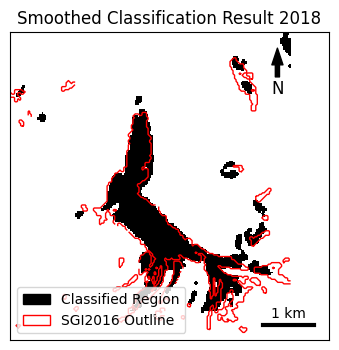


==== Summary for Year: 2018 ====
Accuracy: 0.8992
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94     17588
         1.0       0.74      0.74      0.74      4217

    accuracy                           0.90     21805
   macro avg       0.84      0.84      0.84     21805
weighted avg       0.90      0.90      0.90     21805



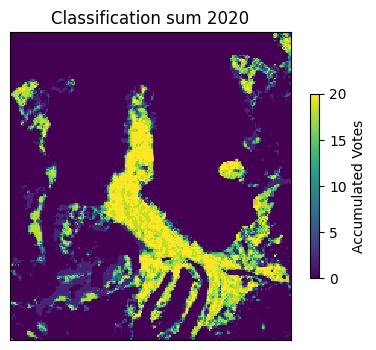

Threshold used (Otsu): 12.00


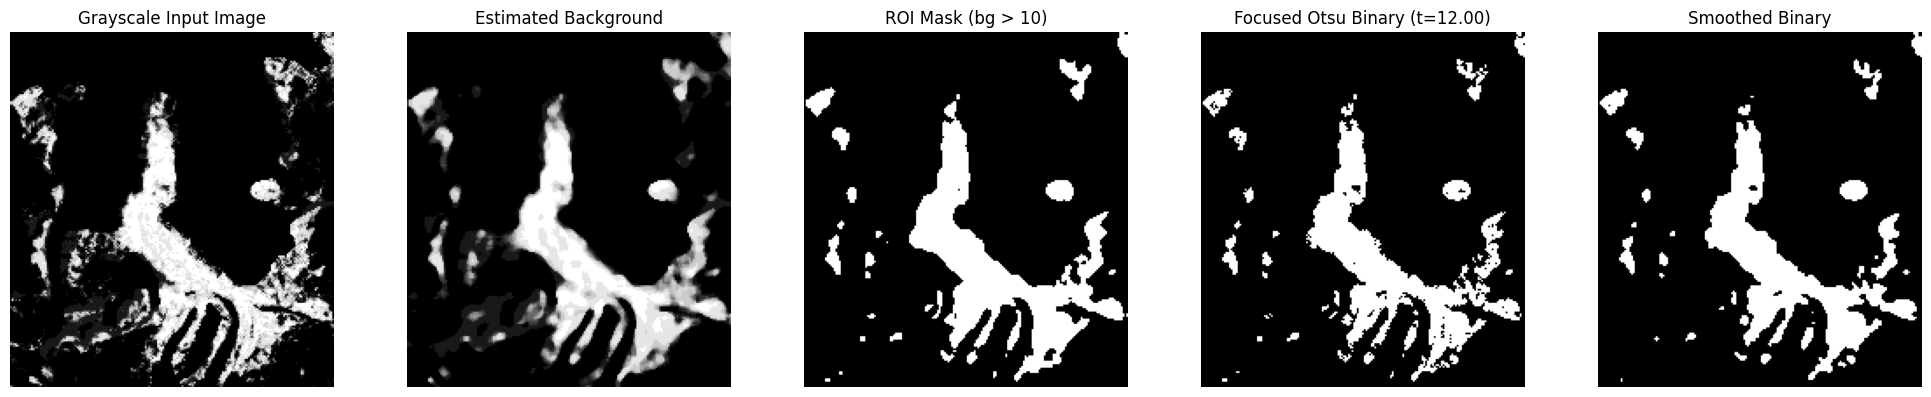

Final Accuracy (after thresholding and smoothing) 2020: 0.8805
Classification Report for final result 2020:
              precision    recall  f1-score   support

         0.0       0.96      0.89      0.92     17588
         1.0       0.65      0.83      0.73      4217

    accuracy                           0.88     21805
   macro avg       0.80      0.86      0.83     21805
weighted avg       0.90      0.88      0.89     21805



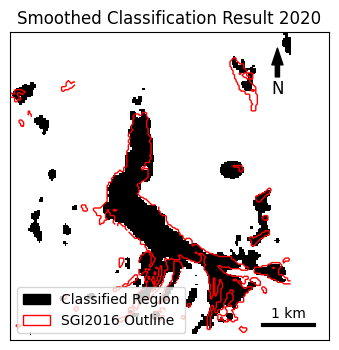


==== Summary for Year: 2020 ====
Accuracy: 0.8805
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.89      0.92     17588
         1.0       0.65      0.83      0.73      4217

    accuracy                           0.88     21805
   macro avg       0.80      0.86      0.83     21805
weighted avg       0.90      0.88      0.89     21805



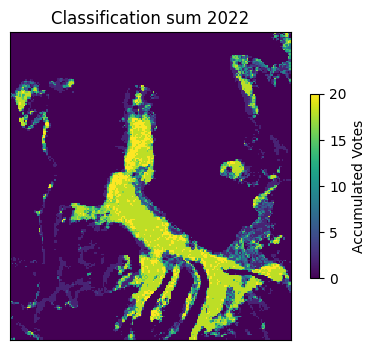

Threshold used (Otsu): 12.00


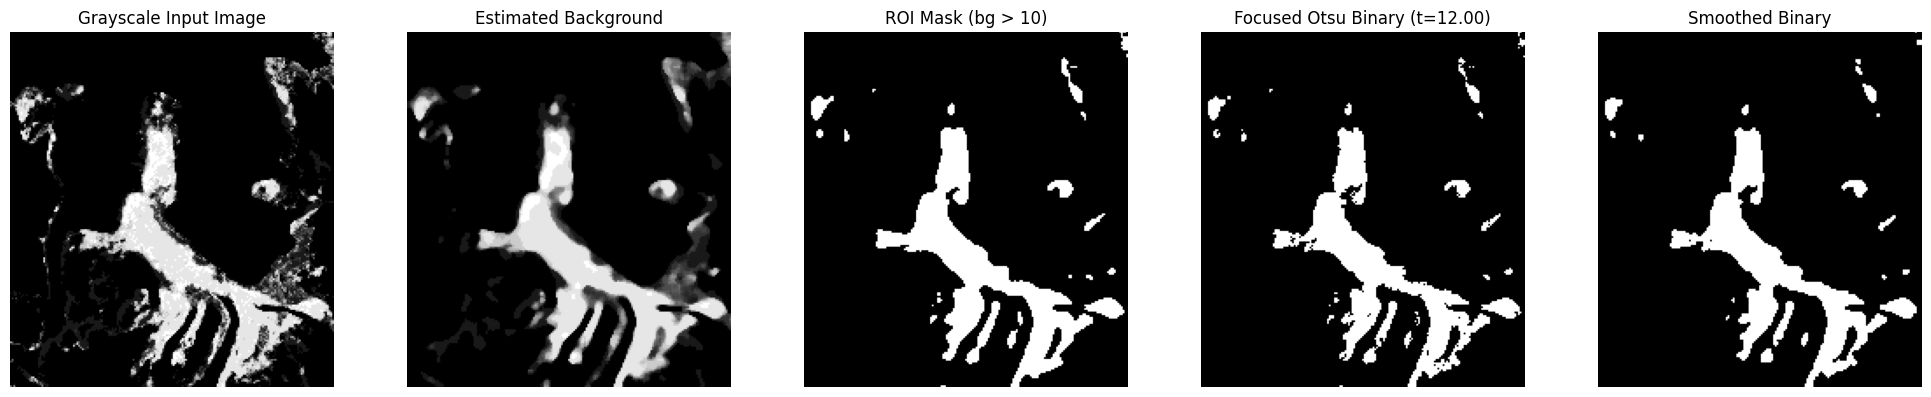

Final Accuracy (after thresholding and smoothing) 2022: 0.8996
Classification Report for final result 2022:
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94     17588
         1.0       0.73      0.76      0.75      4217

    accuracy                           0.90     21805
   macro avg       0.84      0.85      0.84     21805
weighted avg       0.90      0.90      0.90     21805



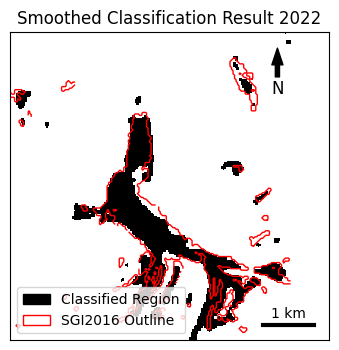


==== Summary for Year: 2022 ====
Accuracy: 0.8996
Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.94     17588
         1.0       0.73      0.76      0.75      4217

    accuracy                           0.90     21805
   macro avg       0.84      0.85      0.84     21805
weighted avg       0.90      0.90      0.90     21805



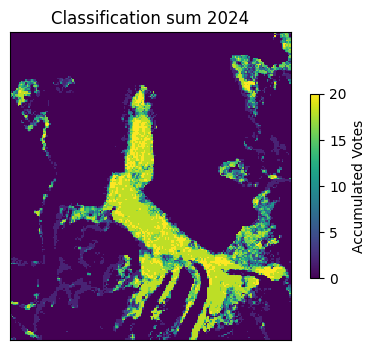

Threshold used (Otsu): 13.00


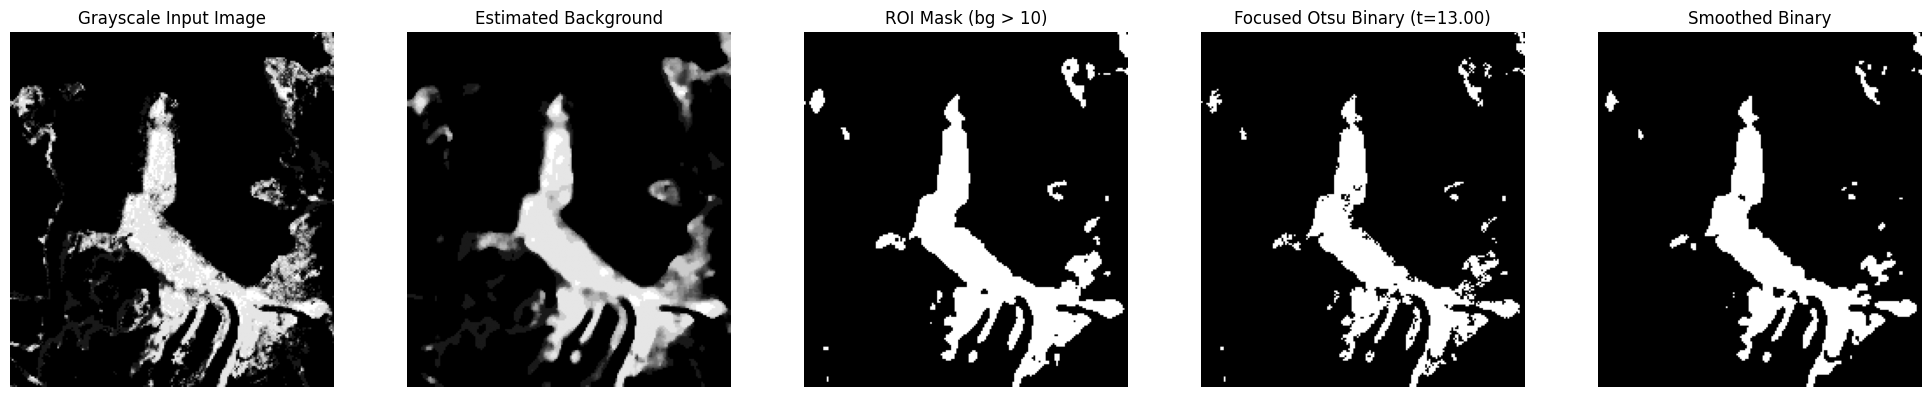

Final Accuracy (after thresholding and smoothing) 2024: 0.8932
Classification Report for final result 2024:
              precision    recall  f1-score   support

         0.0       0.95      0.92      0.93     17588
         1.0       0.70      0.78      0.74      4217

    accuracy                           0.89     21805
   macro avg       0.82      0.85      0.84     21805
weighted avg       0.90      0.89      0.90     21805



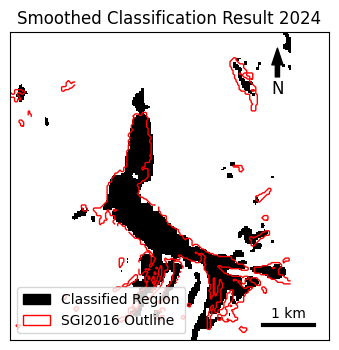


==== Summary for Year: 2024 ====
Accuracy: 0.8932
Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.92      0.93     17588
         1.0       0.70      0.78      0.74      4217

    accuracy                           0.89     21805
   macro avg       0.82      0.85      0.84     21805
weighted avg       0.90      0.89      0.90     21805



In [129]:
from skimage.filters import threshold_otsu
from skimage.measure import find_contours
from scipy.ndimage import median_filter, gaussian_filter
from matplotlib.patches import Patch
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import os
import matplotlib.pyplot as plt
import rasterio

smoothed_images = {}
smoothed_images_flat = {}
reports_by_year = {}
accuracies_all = {}

for year in test_year:
    # Load ensemble result raster
    path1 = f"/content/drive/MyDrive/ensemble_results/{test_glacier}_{year}_ensemble_result.tif"
    ensemble_result = read_raster(path1)  # assuming read_raster is defined elsewhere

    # Plot classification sum image (ensemble result)
    fig, ax = plt.subplots(figsize=(5, 4))
    im = ax.imshow(ensemble_result, interpolation='nearest', cmap="viridis")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    cbar = plt.colorbar(im, ax=ax, shrink=0.6)
    cbar.set_label("Accumulated Votes")
    plt.title(f"Classification sum {year}")
    plt.show()

    # Prepare label mask and masked ensemble result for thresholding
    label = label_data[test_glacier]
    label_mask = (~np.isnan(label)).squeeze()
    ensemble_result_masked = ensemble_result[label_mask]

    # Background estimation function
    def estimate_background(image, window_size):
        return median_filter(image, size=window_size)

    # Focused Otsu thresholding function
    def focused_otsu(image, background, bg_thresh):
        roi_mask = background > bg_thresh
        values_in_roi = image[roi_mask]
        if len(values_in_roi) == 0:
            print("Warning: no pixels above background threshold.")
            return np.zeros_like(image, dtype=np.uint8), roi_mask, 0
        otsu_val = threshold_otsu(values_in_roi)
        binary = np.zeros_like(image, dtype=np.uint8)
        binary[(image > otsu_val) & roi_mask] = 1
        return binary, roi_mask, otsu_val

    # Estimate background with median filter (window=5)
    background = estimate_background(ensemble_result, window_size=5)

    # Apply focused Otsu thresholding with bg_thresh=10
    binary_classification, roi_mask, otsu_val = focused_otsu(ensemble_result, background, bg_thresh=10)
    print(f"Threshold used (Otsu): {otsu_val:.2f}")

    # Smooth binary classification with Gaussian filter
    smoothed_image = gaussian_filter(binary_classification.astype(float), sigma=1)
    smoothed_image = np.round(smoothed_image).astype(np.uint8)
    smoothed_images[year] = smoothed_image

    # Plot intermediate results
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    titles = [
        "Grayscale Input Image",
        "Estimated Background",
        "ROI Mask (bg > 10)",
        f"Focused Otsu Binary (t={otsu_val:.2f})",
        "Smoothed Binary"
    ]
    images = [
        ensemble_result,
        background,
        roi_mask.astype(np.uint8) * 255,
        binary_classification.astype(np.uint8) * 255,
        smoothed_image.astype(np.uint8) * 255
    ]

    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap="gray")
        ax.set_title(title)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

    # Export smoothed image to GeoTIFF
    raster_data = smoothed_image
    height, width = raster_data.shape
    transform = binary_meta["transform"]  # assuming binary_meta is defined elsewhere
    crs = binary_meta["crs"]

    output_dir = "/content/drive/MyDrive/smoothed_images"
    os.makedirs(output_dir, exist_ok=True)
    raster_path = os.path.join(output_dir, f"{test_glacier}_{year}_smoothed_image.tif")

    with rasterio.open(
        raster_path,
        "w",
        driver="GTiff",
        height=height,
        width=width,
        count=1,
        dtype=raster_data.dtype,
        crs=crs,
        transform=transform,
    ) as dst:
        dst.write(raster_data, 1)

    # Calculate accuracy of final classification
    smoothed_image_flat = smoothed_image[label_mask].ravel()
    smoothed_images_flat[year] = smoothed_image_flat.copy()

    y_true = label_data[test_glacier][label_mask].ravel()
    accuracy = accuracy_score(y_true, smoothed_image_flat)
    accuracies_all[year] = accuracy
    print(f"Final Accuracy (after thresholding and smoothing) {year}: {accuracy:.4f}")

    # Print classification report
    report = classification_report(y_true, smoothed_image_flat)
    reports_by_year[year] = report
    print(f"Classification Report for final result {year}:")
    print(report)

    # Plot smoothed classification with ground truth contours
    fig, ax = plt.subplots(figsize=(5, 4))
    im = ax.imshow(smoothed_image, interpolation='nearest', cmap="binary")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    label_2d = label_data[test_glacier].squeeze()
    contours = find_contours(label_2d, level=0.5)
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color="red")

    legend_elements = [
        Patch(facecolor="black", edgecolor="black", label="Classified Region"),
        Patch(facecolor="white", edgecolor="red", label="SGI2016 Outline")
    ]
    ax.legend(handles=legend_elements, loc="lower left", fontsize=10)

    scalebar_length = 33.3
    scalebar_x = smoothed_image.shape[1] * 0.90
    scalebar_y = smoothed_image.shape[0] * 0.95
    ax.plot([scalebar_x, scalebar_x + scalebar_length], [scalebar_y, scalebar_y], color='black', linewidth=3)
    ax.text(scalebar_x + scalebar_length / 2, scalebar_y - 5, "1 km", ha="center", fontsize=10, color="black")

    north_x = smoothed_image.shape[1] * 0.95
    north_y = smoothed_image.shape[0] * 0.05
    ax.annotate("N", xy=(north_x, north_y), xytext=(north_x, north_y + 30),
                arrowprops=dict(facecolor="black", width=3, headwidth=8),
                fontsize=12, color="black", ha="center")

    plt.title(f"Smoothed Classification Result {year}")
    plt.show()

    print(f"\n==== Summary for Year: {year} ====")
    print(f"Accuracy: {accuracies_all[year]:.4f}")
    print("Classification Report:")
    print(reports_by_year[year])


8. Clean up binary classification result (optional)
---
In this section, artifacts and holes in the classification result can be removed. Because of the risk of excluding actual DCG areas, this part is optional and not included per default.

Cleaning glacier mask for year 2016...
Done with 2016: 3634 glacier pixels retained

Cleaning glacier mask for year 2018...
Done with 2018: 4249 glacier pixels retained

Cleaning glacier mask for year 2020...
Done with 2020: 5328 glacier pixels retained

Cleaning glacier mask for year 2022...
Done with 2022: 4389 glacier pixels retained

Cleaning glacier mask for year 2024...
Done with 2024: 4626 glacier pixels retained



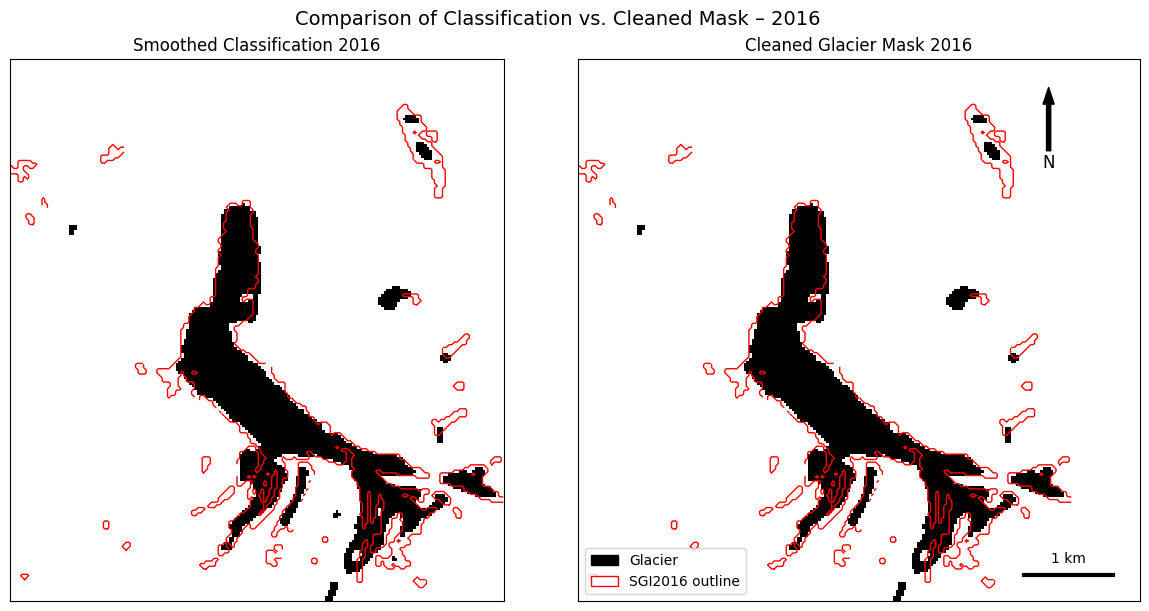

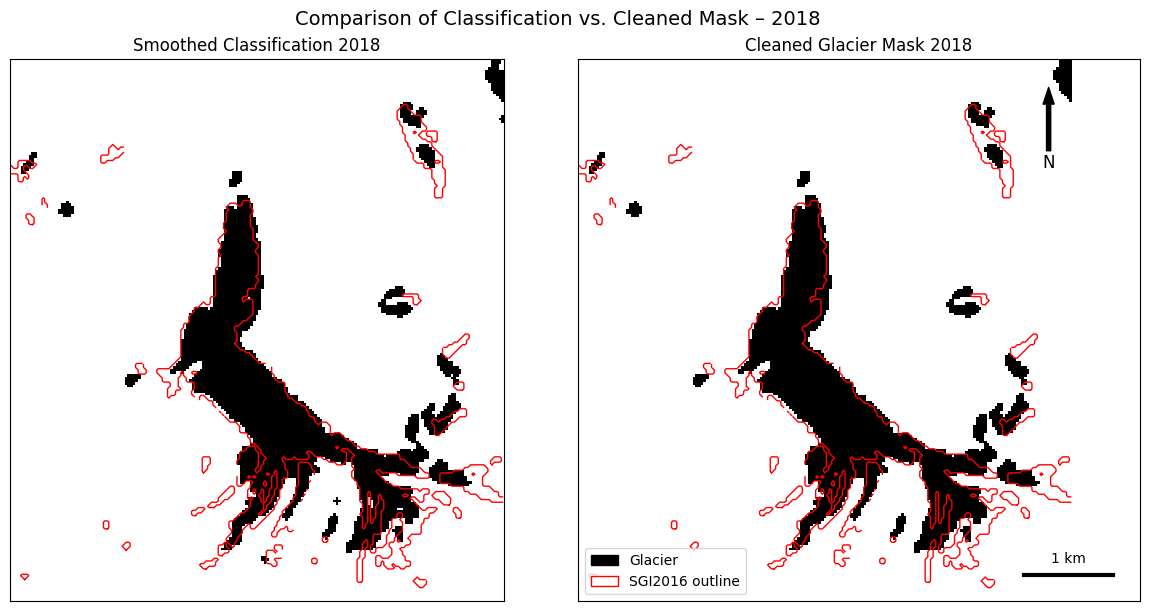

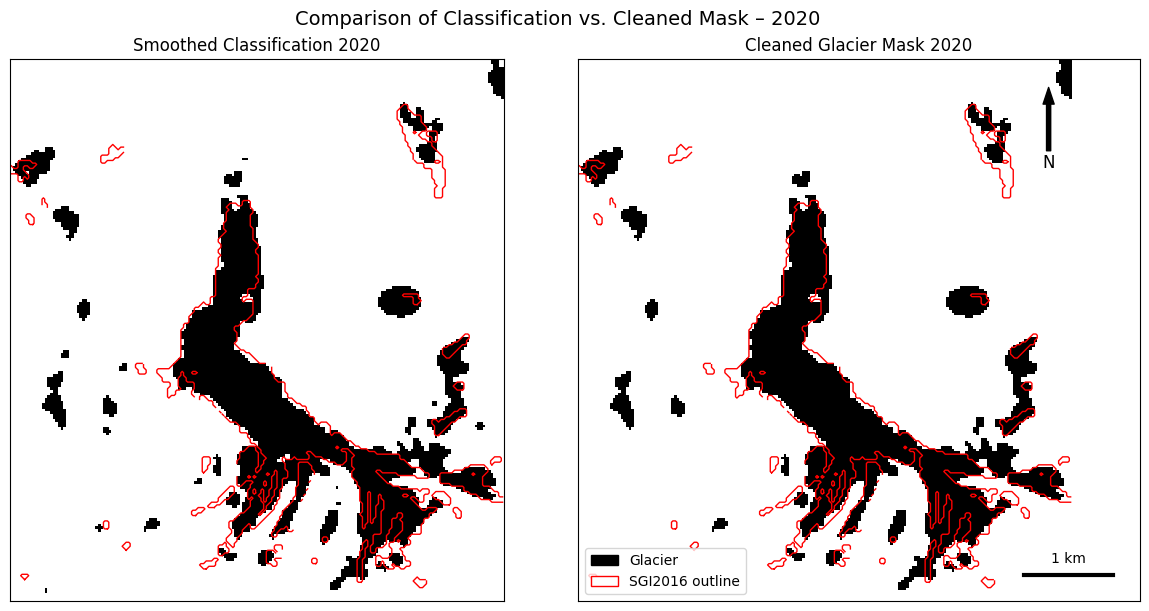

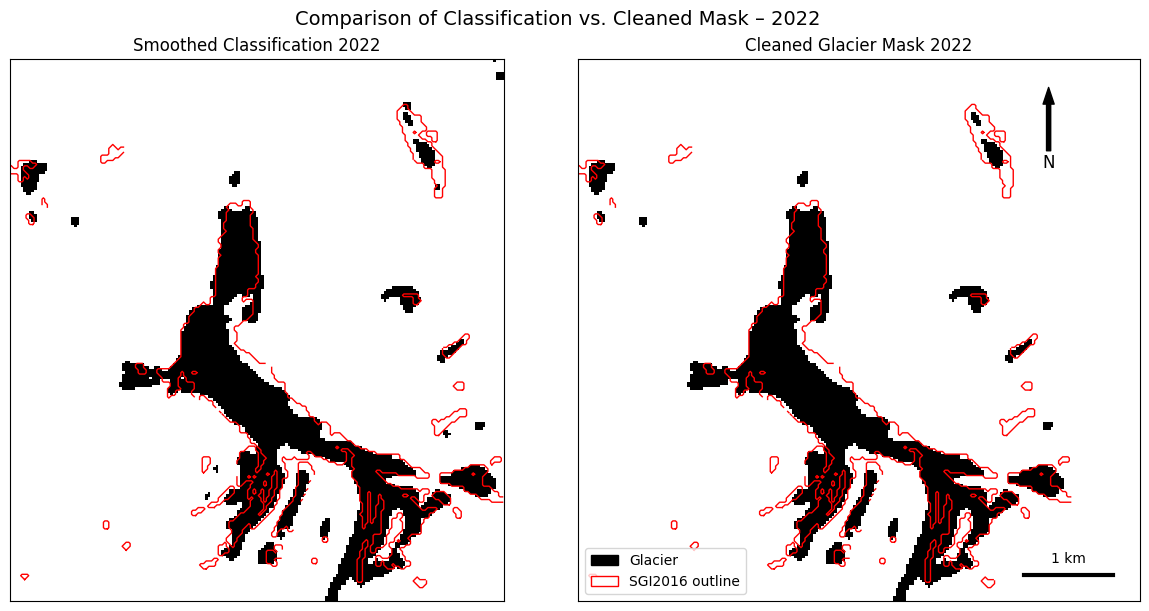

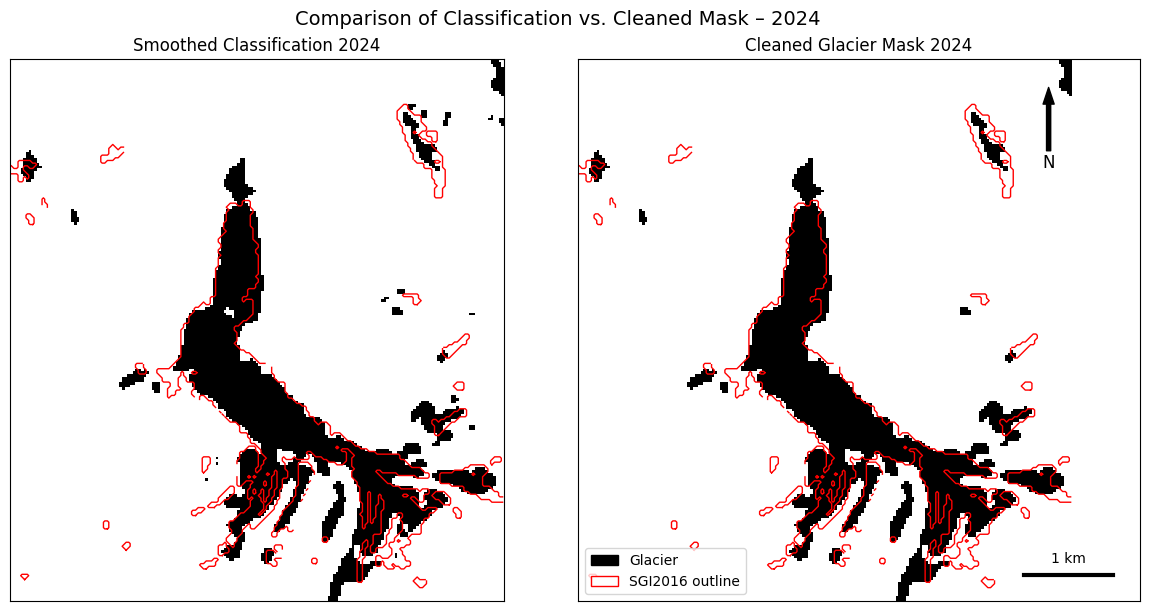

In [130]:

import numpy as np
from scipy import ndimage
from skimage.morphology import remove_small_objects, remove_small_holes
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from skimage import measure
from matplotlib.colors import ListedColormap

# Parameters: can be adjusted
min_glacier_area = 10  # Minimum number of pixels to keep a blob (artifact removal)
hole_area_threshold = 10  # Maximum hole size to fill (in pixels)

# Dictionary to store cleaned raster images
cleaned_images = {}

for year, smoothed_image in smoothed_images.items():
    print(f"Cleaning glacier mask for year {year}...")

    # 1. Ensure binary image: 1 for glacier, 0 for background
    binary = smoothed_image > 0

    # 2. Remove small artifacts (false positives)
    binary_cleaned = remove_small_objects(binary, min_size=min_glacier_area)

    # 3. Optional: keep only the largest connected component (commented out here)
    # labeled_array, num_features = ndimage.label(binary_cleaned)
    # if num_features > 0:
    #     sizes = ndimage.sum(binary_cleaned, labeled_array, range(1, num_features + 1))
    #     largest_label = np.argmax(sizes) + 1
    #     main_glacier = labeled_array == largest_label
    # else:
    #     print(f"Warning: No glacier detected in {year}")
    #     main_glacier = binary_cleaned

    # When keeping multiple glacier areas:
    main_glacier = binary_cleaned

    # 4. Fill small holes inside the glacier mask
    glacier_filled = remove_small_holes(main_glacier, area_threshold=hole_area_threshold)

    # 5. Save cleaned result as uint8
    cleaned_images[year] = glacier_filled.astype(np.uint8)

    print(f"Done with {year}: {np.sum(glacier_filled)} glacier pixels retained\n")

# Define binary colormap for plotting
binary_cmap = ListedColormap(['white', 'black'])  # 0: white, 1: black

for year, smoothed_image in smoothed_images.items():
    glacier_filled = cleaned_images[year]
    binary_original = smoothed_image > 0

    # Ground truth outline contours
    label_2d = label_data[test_glacier].squeeze()
    contours = measure.find_contours(label_2d, level=0.5)

    # Create side-by-side plots: original smoothed vs cleaned mask
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)

    # Left plot: original smoothed classification
    ax1 = axes[0]
    ax1.imshow(binary_original, interpolation='nearest', cmap=binary_cmap)
    ax1.set_title(f"Smoothed Classification {year}", fontsize=12)
    ax1.set_xticks([]), ax1.set_yticks([])
    ax1.set_aspect('equal')

    for contour in contours:
        ax1.plot(contour[:, 1], contour[:, 0], linewidth=1, color="red")

    # Right plot: cleaned glacier mask
    ax2 = axes[1]
    ax2.imshow(glacier_filled, interpolation='nearest', cmap=binary_cmap)
    ax2.set_title(f"Cleaned Glacier Mask {year}", fontsize=12)
    ax2.set_xticks([]), ax2.set_yticks([])
    ax2.set_aspect('equal')

    for contour in contours:
        ax2.plot(contour[:, 1], contour[:, 0], linewidth=1, color="red")

    # Legend (only on right plot)
    legend_elements = [
        Patch(facecolor="black", edgecolor="black", label="Glacier"),
        Patch(facecolor="white", edgecolor="red", label="SGI2016 outline")
    ]
    ax2.legend(handles=legend_elements, loc="lower left", fontsize=10)

    # Add scale bar (~1 km) to right plot
    scalebar_length = 33.3  # pixels corresponding to ~1 km at 30m resolution
    scalebar_x = smoothed_image.shape[1] * 0.90
    scalebar_y = smoothed_image.shape[0] * 0.95
    ax2.plot([scalebar_x, scalebar_x + scalebar_length], [scalebar_y, scalebar_y],
             color='black', linewidth=3)
    ax2.text(scalebar_x + scalebar_length / 2, scalebar_y - 5, "1 km",
             ha="center", fontsize=10, color="black")

    # Add north arrow to right plot
    north_x = smoothed_image.shape[1] * 0.95
    north_y = smoothed_image.shape[0] * 0.05
    ax2.annotate("N", xy=(north_x, north_y), xytext=(north_x, north_y + 30),
                 arrowprops=dict(facecolor="black", width=3, headwidth=8),
                 fontsize=12, color="black", ha="center")

    plt.suptitle(f"Comparison of Classification vs. Cleaned Mask – {year}", fontsize=14)
    plt.show()


9. Generate consensus glacier polygon
---
This section creates a consensus glacier polygon from the binary results over multiple years. It stacks the raster masks, applies a minimum overlap threshold to find stable glacier areas, reprojects the raster to a target CRS, vectorizes the glacier mask contours, cleans the polygons, and unions them into a final consensus glacier outline which is saved as a shapefile.
If cleaned masks shall be used, change "smoothed_images" to "cleaned_images".


In [131]:
# Generate consensus glacier polygon from cleaned masks

from skimage import measure
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union
from shapely.validation import make_valid
from rasterio.warp import reproject, calculate_default_transform, Resampling

# --- Configurable parameters ---
min_overlap_years = 3          # Minimum number of years a pixel must be glacier to be included
pixel_size = 30                # Pixel size in meters
min_polygon_area = 100         # Minimum polygon area in m² to keep
dst_crs = "EPSG:32632"         # Target CRS (UTM zone, adjust if needed)
output_path = f"/content/drive/MyDrive/avg_polygons/avg_polygon_{test_glacier}.shp"

# --- Step 1: Stack cleaned glacier masks ---
# years_sorted = sorted(smoothed_images.keys())
years_sorted = [2020, 2022, 2024] # selecting only these years for composite
print("years_sorted:", years_sorted)

glacier_stack = np.array([smoothed_images[year] for year in years_sorted])
overlap_map = np.sum(glacier_stack, axis=0)
binary_consensus = (overlap_map >= min_overlap_years).astype(np.uint8)

# --- Step 2: Reproject the consensus mask to target CRS ---
src_crs = binary_meta["crs"]
src_transform = binary_meta["transform"]
src_height, src_width = binary_consensus.shape

dst_transform, dst_width, dst_height = calculate_default_transform(
    src_crs, dst_crs, src_width, src_height, *rasterio.transform.array_bounds(
        src_height, src_width, src_transform
    )
)

reprojected_binary = np.zeros((dst_height, dst_width), dtype=np.uint8)

reproject(
    source=binary_consensus,
    destination=reprojected_binary,
    src_transform=src_transform,
    src_crs=src_crs,
    dst_transform=dst_transform,
    dst_crs=dst_crs,
    resampling=Resampling.nearest
)

# Optional: visualize reprojected mask
# plt.imshow(reprojected_binary, cmap='gray')
# plt.title("Reprojected Mask")
# plt.colorbar()
# plt.show()

# --- Step 3: Vectorize raster mask to polygons ---
polygons = []
contours = measure.find_contours(reprojected_binary, level=0.5)

for contour in contours:
    row_coords, col_coords = contour[:, 0], contour[:, 1]
    xs, ys = rasterio.transform.xy(dst_transform, row_coords, col_coords)
    coords = list(zip(xs, ys))
    poly = Polygon(coords)
    if poly.area > min_polygon_area:
        polygons.append(poly)

# --- Step 4: Clean polygons and create union ---
valid_polygons = []
for poly in polygons:
    if not poly.is_valid:
        fixed = make_valid(poly)
        if isinstance(fixed, Polygon):
            valid_polygons.append(fixed)
        elif isinstance(fixed, MultiPolygon):
            valid_polygons.extend(fixed.geoms)
    else:
        valid_polygons.append(poly)

if not valid_polygons:
    print("No valid polygons found in reprojected consensus mask.")
else:
    unioned = unary_union(valid_polygons)
    geoms = [unioned] if isinstance(unioned, Polygon) else list(unioned.geoms)

    avg_gdf = gpd.GeoDataFrame(geometry=geoms, crs=dst_crs)
    avg_gdf.to_file(output_path)
    print(f"Saved consensus glacier outline to {output_path}")


years_sorted: [2020, 2022, 2024]
Saved consensus glacier outline to /content/drive/MyDrive/avg_polygons/avg_polygon_zinal.shp


10. Vectorize and store results
---
This code converts the smoothed glacier classification raster (class 1 = glacier) for each year into vector polygons using rasterio's shapes function, then simplifies the geometries to reduce jagged edges caused by rasterization. Each year's polygon shapefile is saved separately.


In [132]:
from rasterio.features import shapes
from shapely.geometry import shape

for year in years:
    # Only retain the foreground glacier class (assumed to be 1)
    smoothed_image = smoothed_images[year]
    mask = smoothed_image == 1

    # Use raster metadata for georeferencing
    transform = binary_meta["transform"]
    crs = binary_meta["crs"]

    # Vectorize binary raster to polygons
    shapes_generator = shapes(smoothed_image.astype(np.uint8), mask=mask, transform=transform)
    geometries = [shape(geom) for geom, val in shapes_generator if val == 1]

    # Create GeoDataFrame with original CRS
    gdf = gpd.GeoDataFrame(geometry=geometries, crs=crs)

    # Simplify polygons to smooth jagged edges (tolerance adjustable)
    tolerance = 0  # e.g., 2 meters, adjust as needed
    gdf['geometry'] = gdf['geometry'].simplify(tolerance, preserve_topology=True)

    # Save shapefile for the year
    output_path = f"/content/drive/MyDrive/final_polygon_{test_glacier}_{year}.shp"
    gdf.to_file(output_path)

    # Uncomment to print confirmation:
    # print(f"Saved smoothed polygon shapefile to: {output_path}")


11. Plot DCG outlines of different years
---
This code reads the final polygon shapefiles for each year, plots them together with different colors,
overlays satellite basemaps, adds the RGI glacier outlines, the SGI2016 outline, and the average polygon.
Two plots are created: a full extent overview and a zoomed-in view with scale bar and north arrow.

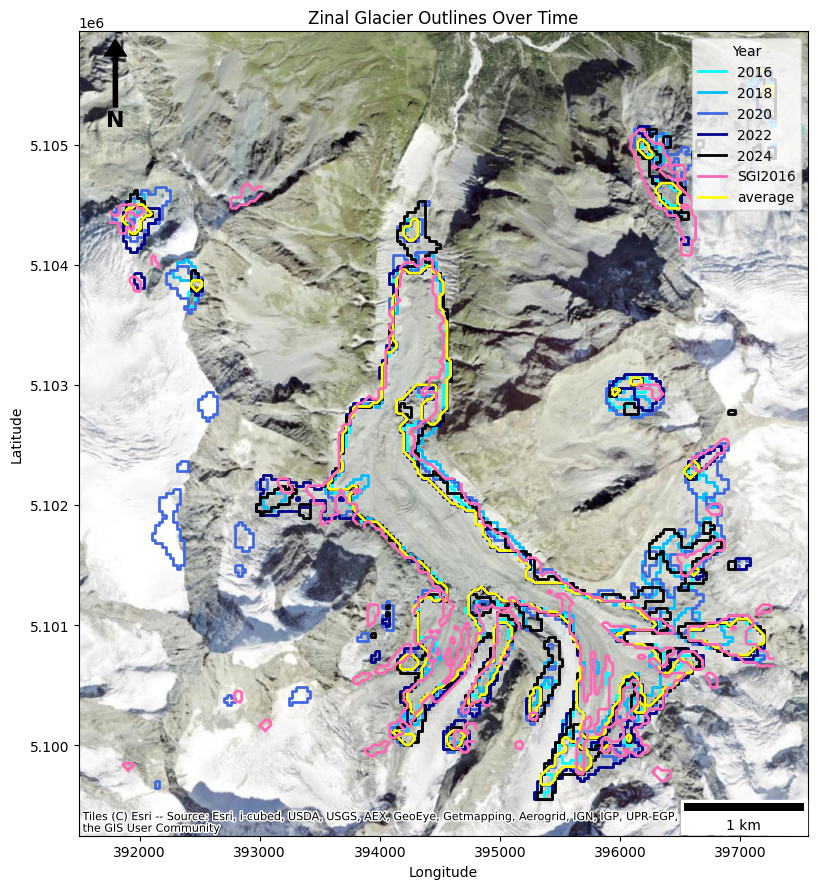

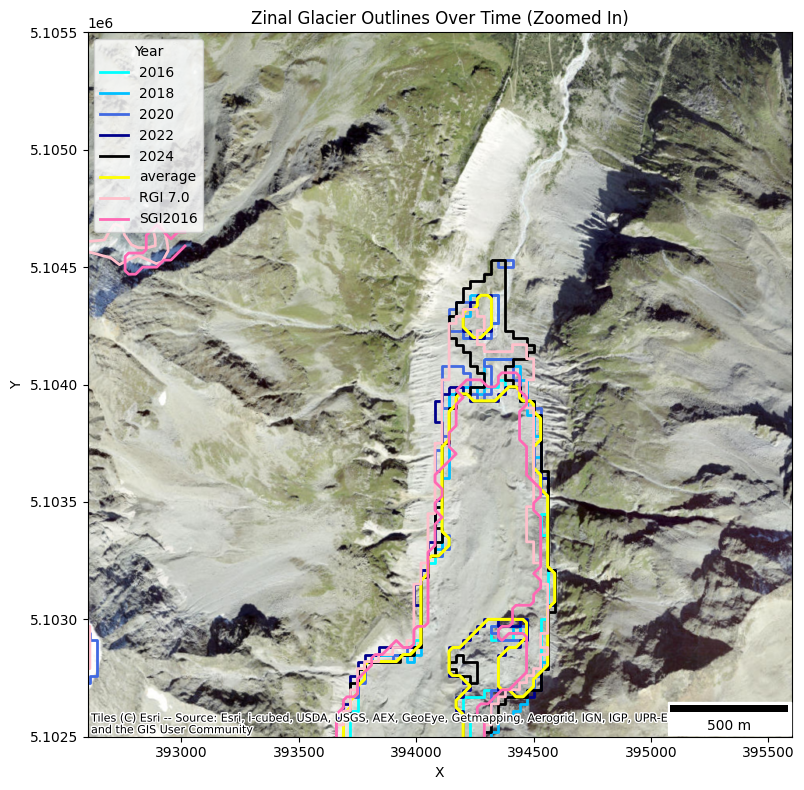

In [133]:
from rasterio.plot import plotting_extent
from matplotlib.colors import LightSource, Normalize
import matplotlib.cm as cm
import matplotlib.lines as mlines
import os

# Add the RGI to the plots for comparison:

rgi_path = {
    "zmutt": "/content/drive/My Drive/rgi7/RGI2000-v7.0-G-11_central_europe.shp",
    "unteraar": "/content/drive/My Drive/rgi7/RGI2000-v7.0-G-11_central_europe.shp",
    "belvedere": "/content/drive/My Drive/rgi7/RGI2000-v7.0-G-11_central_europe.shp",
    "oberaletsch": "/content/drive/My Drive/rgi7/RGI2000-v7.0-G-11_central_europe.shp",
    "zinal": "/content/drive/My Drive/rgi7/RGI2000-v7.0-G-11_central_europe.shp",
    "mauvoisin": "/content/drive/My Drive/rgi7/RGI2000-v7.0-G-11_central_europe.shp",
    "satopanth": "/content/drive/My Drive/rgi7/rgi_v7_satopanth.shp"
}
rgi_data = {}
for glacier, path in rgi_path.items():
    rgi_data[glacier] = gpd.read_file(path)
rgi_clipped = {}
for glacier in glaciers:
    buffer_geom = buffers[glacier]
    rgi_clipped[glacier] = rgi_data[glacier].clip(buffer_geom)

# Can re-define test-glacier if all data was stored before (to avoid running the whole script again):
# test_glacier = 'zmutt' # oberaletsch, unteraar, zinal, mauvoisin, belvedere, satopanth

# Define output directory for plots
plot_output_dir = f"/content/drive/MyDrive/glacier_outline_plots/{test_glacier}"
os.makedirs(plot_output_dir, exist_ok=True)

# Correcting label_data shape by squeezing out any extra dimensions
label_2d = label_data[test_glacier].squeeze()

# --- CONFIGURATION ---
colors = [ 'cyan', 'deepskyblue', 'royalblue', 'darkblue', 'black']
elevation_band_index = 10  # zero-based

# --- Create one plot
fig, ax = plt.subplots(figsize=(12, 9))

# --- Plot outlines for each year
legend_elements = []
for year, color in zip(years, colors):
    shapefile_path = f"/content/drive/MyDrive/final_polygon_{test_glacier}_{year}.shp"
    gdf = gpd.read_file(shapefile_path).to_crs(crs)
    gdf.plot(ax=ax, facecolor='none', edgecolor=color, linewidth=2)
    legend_elements.append(mlines.Line2D([], [], color=color, linewidth=2, label=str(year)))

# ax.imshow(rgb, extent=extent)
from skimage import measure
from rasterio.transform import xy
import contextily as ctx

# Add satellite basemap from contextily
ctx.add_basemap(ax, crs = crs, source=ctx.providers.Esri.WorldImagery)

#avg_gdf.to_file(f"/content/drive/MyDrive/avg_polygon_{test_glacier}.shp")

# Find contours in the label data
contours = measure.find_contours(label_2d, level=0.5)

# Convert pixel coordinates to spatial coordinates and plot them
plotted = False
for contour in contours:
    row_coords, col_coords = contour[:, 0], contour[:, 1]
    xs, ys = xy(transform, row_coords, col_coords)
    if not plotted:
      ax.plot(xs, ys, linewidth=2, color='hotpink', label="SGI2016 Outline")
      legend_elements.append(mlines.Line2D([], [], color='hotpink', linewidth=2, label='SGI2016')) #'SGI2016'
      plotted = True
    else:
        ax.plot(xs, ys, linewidth=2, color='hotpink')

# --- North Arrow
arrow_props = dict(facecolor='black', width=3, headwidth=16)
ax.annotate('N', xy=(0.05, 0.99), xytext=(0.05, 0.89),
            arrowprops=arrow_props, ha='center', va='center',
            xycoords='axes fraction', fontsize=16, fontweight='bold')

from matplotlib_scalebar.scalebar import ScaleBar
scalebar = ScaleBar(dx=1, units='m',
                    location='lower right',
                    length_fraction=0.2,
                    box_color='white', box_alpha=1)  # Full opacity
ax.add_artist(scalebar)

average_outline_path = f"/content/drive/MyDrive/avg_polygons/avg_polygon_{test_glacier}.shp"
gdf_average = gpd.read_file(average_outline_path)
gdf_average = gdf_average.to_crs(crs)         # for full plot
gdf_average.plot(ax=ax, facecolor='none', edgecolor='yellow', linewidth=2)
legend_elements.append(mlines.Line2D([], [], color='yellow', linewidth=2, label='average'))

# --- Legend & Labels
ax.legend(handles=legend_elements, title="Year", loc='upper right')
ax.set_title(f"{test_glacier.capitalize()} Glacier Outlines Over Time")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()

plot_path_1 = os.path.join(plot_output_dir, f"{test_glacier}_outlines_over_time_full.png")
plt.savefig(plot_path_1, dpi=300, bbox_inches='tight')

plt.show()

import matplotlib.pyplot as plt
import contextily as ctx
from pyproj import Transformer
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.lines as mlines

raster_crs = crs

# --- Target coordinates (manually assigned for zoomed-in plot)
if test_glacier == 'zmutt':
    y, x = 5094800, 395900
    crs_epsg = raster_crs
elif test_glacier == 'mauvoisin':
    y, x = 5087500, 372200
    crs_epsg = raster_crs
elif test_glacier == 'mauvoisin1':
    y, x = 5090000, 371000
    crs_epsg = raster_crs
elif test_glacier == 'oberaletsch':
    y, x = 5140000, 422800
    crs_epsg = raster_crs
elif test_glacier == 'zinal':
    y, x = 5104000, 394100
    crs_epsg = raster_crs
elif test_glacier == 'unteraar':
    y, x = 5157000, 442000
    crs_epsg = raster_crs
elif test_glacier == 'belvedere':
    # Belvedere is in lat/lon (EPSG:4326), convert to EPSG:3857
    lat, lon = 45.963, 7.915
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
    x, y = transformer.transform(lon, lat)
    crs_epsg = "EPSG:3857"
elif test_glacier == 'satopanth':
    x, y = 347700, 3406000
    crs_epsg = raster_crs
else:
    raise ValueError(f"Unknown glacier name: {test_glacier}")

# Set buffer
x_buffer = 1500  # 1 km
y_buffer = 1500
xlim = (x - x_buffer, x + x_buffer)
ylim = (y - y_buffer, y + y_buffer)

# --- Plot
fig, ax = plt.subplots(figsize=(10, 8))
legend_elements = []

# Plot outlines (reproject if needed)
for year, color in zip(years, colors):
    shapefile_path = f"/content/drive/MyDrive/final_polygon_{test_glacier}_{year}.shp"
    gdf = gpd.read_file(shapefile_path)

    # Reproject to match basemap CRS
    gdf = gdf.to_crs(crs_epsg)
    gdf.plot(ax=ax, facecolor='none', edgecolor=color, linewidth=2)
    legend_elements.append(mlines.Line2D([], [], color=color, linewidth=2, label=str(year)))
gdf_average = gpd.read_file(average_outline_path)
gdf_average = gdf_average.to_crs(crs_epsg)  # <-- ADD THIS
gdf_average.plot(ax=ax, facecolor='none', edgecolor='yellow', linewidth=2)

gdf_average.plot(ax=ax, facecolor='none', edgecolor='yellow', linewidth=2)
legend_elements.append(mlines.Line2D([], [], color='yellow', linewidth=2, label='average'))

# Plot RGI if available
if 'rgi_data' in globals() and test_glacier in rgi_data:
    rgi = rgi_data[test_glacier].to_crs(crs_epsg)
    rgi.plot(ax=ax, facecolor='none', edgecolor='pink', linewidth=2)
    legend_elements.append(mlines.Line2D([], [], color='pink', linewidth=2, label='RGI 7.0'))

# Set limits
ax.set_xlim(xlim)
ax.set_ylim(ylim)

# Add basemap
ctx.add_basemap(ax, crs=crs_epsg, source=ctx.providers.Esri.WorldImagery)
plotted = False
for contour in contours:
    row_coords, col_coords = contour[:, 0], contour[:, 1]
    xs, ys = xy(transform, row_coords, col_coords)
    if not plotted:
      ax.plot(xs, ys, linewidth=2, color='hotpink', label="SGI2016 Outline")
      legend_elements.append(mlines.Line2D([], [], color='hotpink', linewidth=2, label='SGI2016')) #'SGI2016'
      plotted = True
    else:
        ax.plot(xs, ys, linewidth=2, color='hotpink')

# Scale bar
scalebar = ScaleBar(dx=1, units='m',
                    location='lower right',
                    length_fraction=0.2,
                    box_color='white', box_alpha=1)
ax.add_artist(scalebar)

# Labels
ax.legend(handles=legend_elements, title="Year", loc='upper left')
ax.set_title(f"{test_glacier.capitalize()} Glacier Outlines Over Time (Zoomed In)")
ax.set_xlabel("Longitude" if "4326" in crs_epsg or "3857" in crs_epsg else "X")
ax.set_ylabel("Latitude" if "4326" in crs_epsg or "3857" in crs_epsg else "Y")

plt.tight_layout()

plot_path_2 = os.path.join(plot_output_dir, f"{test_glacier}_outlines_over_time_zoomed.png")
plt.savefig(plot_path_2, dpi=300, bbox_inches='tight')

plt.show()




12. Polygon-based evaluation against SGI2016
---
This step evaluates the predicted glacier outlines by comparing them with the SGI2016 debriscover. The SGI is clipped to the study area, then spatial metrics like IoU, precision, recall, F1 score, and accuracy are computed based on polygon overlaps. Finally, the SGI2016 and predicted outlines (2016-2024) are plotted together for visual comparison.

Loaded GT debris cover outlines. CRS: EPSG:2056
gdf average crs EPSG:2056
Reprojected GT to match predicted CRS.
gdf average crs EPSG:2056
Clipped GT contains 16 polygons.
GT after clean ice subtraction contains 16 polygons.
Number of polygons after area filter: 6
Total GT area after filter: 4045394.843415901
Polygon-based Evaluation (Vector GT - Clean Ice subtracted):
- IoU:       0.5776
- Precision: 0.8462
- Recall:    0.6454
- F1 Score:  0.7323
- Accuracy:  0.9435 (approx., using study area)


/tmp/ipython-input-134-2331378926.py:46: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  clean_ice_mask = remove_small_holes(clean_ice_mask, area_threshold=20)
/tmp/ipython-input-134-2331378926.py:68: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  clean_ice_union = clean_ice_gdf.unary_union


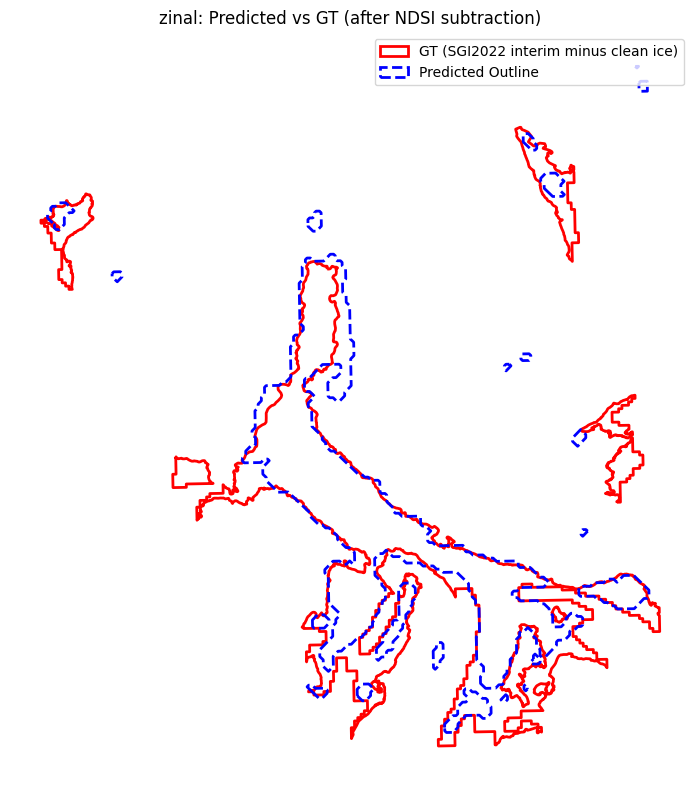

In [134]:
import geopandas as gpd
from shapely.geometry import shape, box
from shapely.ops import unary_union
from rasterio.features import shapes
import rasterio
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
from skimage.morphology import remove_small_objects, remove_small_holes, binary_opening, binary_closing
from skimage.measure import label as sk_label

# Skip evaluation for glaciers outside Switzerland
if test_glacier in ['belvedere', 'satopanth']:
    print("Polygon-based evaluation against the SGI2022 is only possible for DCGs in Switzerland.")
else:
    # === 1. Load GT debris-covered glacier outlines (SGI2022 interim) ===
    gt_path = "/content/drive/MyDrive/interim_SGI2022_inventory/interim_SGI2022_lv95.shp"
    gdf_gt = gpd.read_file(gt_path)
    print("Loaded GT debris cover outlines. CRS:", gdf_gt.crs)

    # === 2. Reproject GT if needed to match predicted outline ===
    if gdf_gt.crs != gdf_average.crs:
        gdf_average = gdf_average.to_crs(gdf_gt.crs)
        print('gdf average crs', gdf_average.crs)
        print("Reprojected GT to match predicted CRS.")
        print('gdf average crs', gdf_average.crs)

    # === 3. Get study area bounds from prediction raster ===
    min_x, min_y, max_x, max_y = rasterio.transform.array_bounds(
        binary_meta['height'], binary_meta['width'], binary_meta['transform']
    )
    study_area_bounds = box(min_x, min_y, max_x, max_y)
    study_area_gdf = gpd.GeoDataFrame(geometry=[study_area_bounds], crs=binary_meta['crs'])

    # === 4. Clip GT to study area ===
    gdf_gt_clipped = gpd.overlay(gdf_gt, study_area_gdf.to_crs(gdf_gt.crs), how='intersection')
    print(f"Clipped GT contains {len(gdf_gt_clipped)} polygons.")

    # === 5. Create clean ice mask from NDSI ===
    ndsi_band = image_data[test_glacier][2022][..., band_indices['ndsi']]
    ndsi_threshold = 0.7
    clean_ice_mask = ndsi_band > ndsi_threshold

    # Morphological cleaning
    clean_ice_mask = remove_small_objects(sk_label(clean_ice_mask), min_size=20)
    clean_ice_mask = remove_small_holes(clean_ice_mask, area_threshold=20)
    from skimage.morphology import binary_opening, binary_closing

    # Replace this:
    # clean_ice_mask = binary_opening(clean_ice_mask, structure=np.ones((3, 3)))
    # clean_ice_mask = binary_closing(clean_ice_mask, structure=np.ones((3, 3)))

    # With this:
    clean_ice_mask = binary_opening(clean_ice_mask, footprint=np.ones((3, 3)))
    clean_ice_mask = binary_closing(clean_ice_mask, footprint=np.ones((3, 3)))

    clean_ice_mask = clean_ice_mask.astype(np.uint8)  # for vectorization

    # === 6. Vectorize clean ice mask ===
    shapes_gen = shapes(clean_ice_mask, transform=binary_meta['transform'])
    clean_ice_polys = [shape(geom) for geom, val in shapes_gen if val == 1]
    clean_ice_gdf = gpd.GeoDataFrame(geometry=clean_ice_polys, crs=binary_meta['crs'])

    if clean_ice_gdf.crs != gdf_gt_clipped.crs:
        clean_ice_gdf = clean_ice_gdf.to_crs(gdf_gt_clipped.crs)

    # === 7. Subtract clean ice from GT outlines ===
    clean_ice_union = clean_ice_gdf.unary_union
    gt_dcg_geometry = gdf_gt_clipped.geometry.map(lambda geom: geom.difference(clean_ice_union))
    gdf_gt_subtracted = gpd.GeoDataFrame(geometry=gt_dcg_geometry, crs=gdf_gt_clipped.crs)
    gdf_gt_subtracted = gdf_gt_subtracted[~gdf_gt_subtracted.is_empty & gdf_gt_subtracted.is_valid]
    print(f"GT after clean ice subtraction contains {len(gdf_gt_subtracted)} polygons.")

    # === 8. Explode MultiPolygons and filter small objects ===
    gdf_gt_subtracted = gdf_gt_subtracted.explode(index_parts=False).reset_index(drop=True)

    if gdf_gt_subtracted.crs != "EPSG:2056":
        gdf_gt_subtracted = gdf_gt_subtracted.to_crs("EPSG:2056")

    gdf_gt_subtracted["area"] = gdf_gt_subtracted.geometry.area
    min_area = 50 * 30 * 30  # m²
    gdf_dcg_filtered = gdf_gt_subtracted[gdf_gt_subtracted["area"] >= min_area].copy()

    # === 9. Union geometries for metric computation ===
    gt_union = unary_union(gdf_dcg_filtered.geometry)
    pred_union = unary_union(gdf_average.geometry)

    # === 10. Compute area-based metrics ===
    intersection_area = pred_union.intersection(gt_union).area
    union_area = pred_union.union(gt_union).area
    pred_area = pred_union.area
    gt_area = gt_union.area
    print("Number of polygons after area filter:", len(gdf_dcg_filtered))
    print("Total GT area after filter:", gdf_dcg_filtered.area.sum())


    if gt_area == 0 or union_area == 0:
        raise ValueError("GT or union area is zero — check CRS, extent, and masks.")

    study_area = study_area_bounds.area
    tn_area = study_area - union_area
    tp_area = intersection_area
    fp_area = pred_area - tp_area
    fn_area = gt_area - tp_area

    accuracy = (tp_area + tn_area) / study_area if study_area > 0 else 0
    iou = tp_area / union_area if union_area > 0 else 0
    precision = tp_area / pred_area if pred_area > 0 else 0
    recall = tp_area / gt_area if gt_area > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    # === 11. Report metrics ===
    print("Polygon-based Evaluation (Vector GT - Clean Ice subtracted):")
    print(f"- IoU:       {iou:.4f}")
    print(f"- Precision: {precision:.4f}")
    print(f"- Recall:    {recall:.4f}")
    print(f"- F1 Score:  {f1:.4f}")
    print(f"- Accuracy:  {accuracy:.4f} (approx., using study area)")

    # === 12. Plot results ===
    fig, ax = plt.subplots(figsize=(8, 8))
    gdf_dcg_filtered.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2)
    gdf_average.plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=2, linestyle='--')

    legend_elements = [
        Patch(edgecolor='red', facecolor='none', label='GT (SGI2022 interim minus clean ice)', linewidth=2),
        Patch(edgecolor='blue', facecolor='none', linestyle='--', label='Predicted Outline', linewidth=2)
    ]
    ax.legend(handles=legend_elements)
    ax.set_title(f"{test_glacier}: Predicted vs GT (after NDSI subtraction)")
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()


/tmp/ipython-input-135-2104314073.py:21: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  clean_ice_mask = remove_small_holes(clean_ice_mask, area_threshold=20)
/tmp/ipython-input-135-2104314073.py:44: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  clean_ice_union = clean_ice_gdf.unary_union


Before filtering: 189 polygons
After filtering: 30 polygons
Filtered area range: 9428.686159714616 - 2729684.393604156


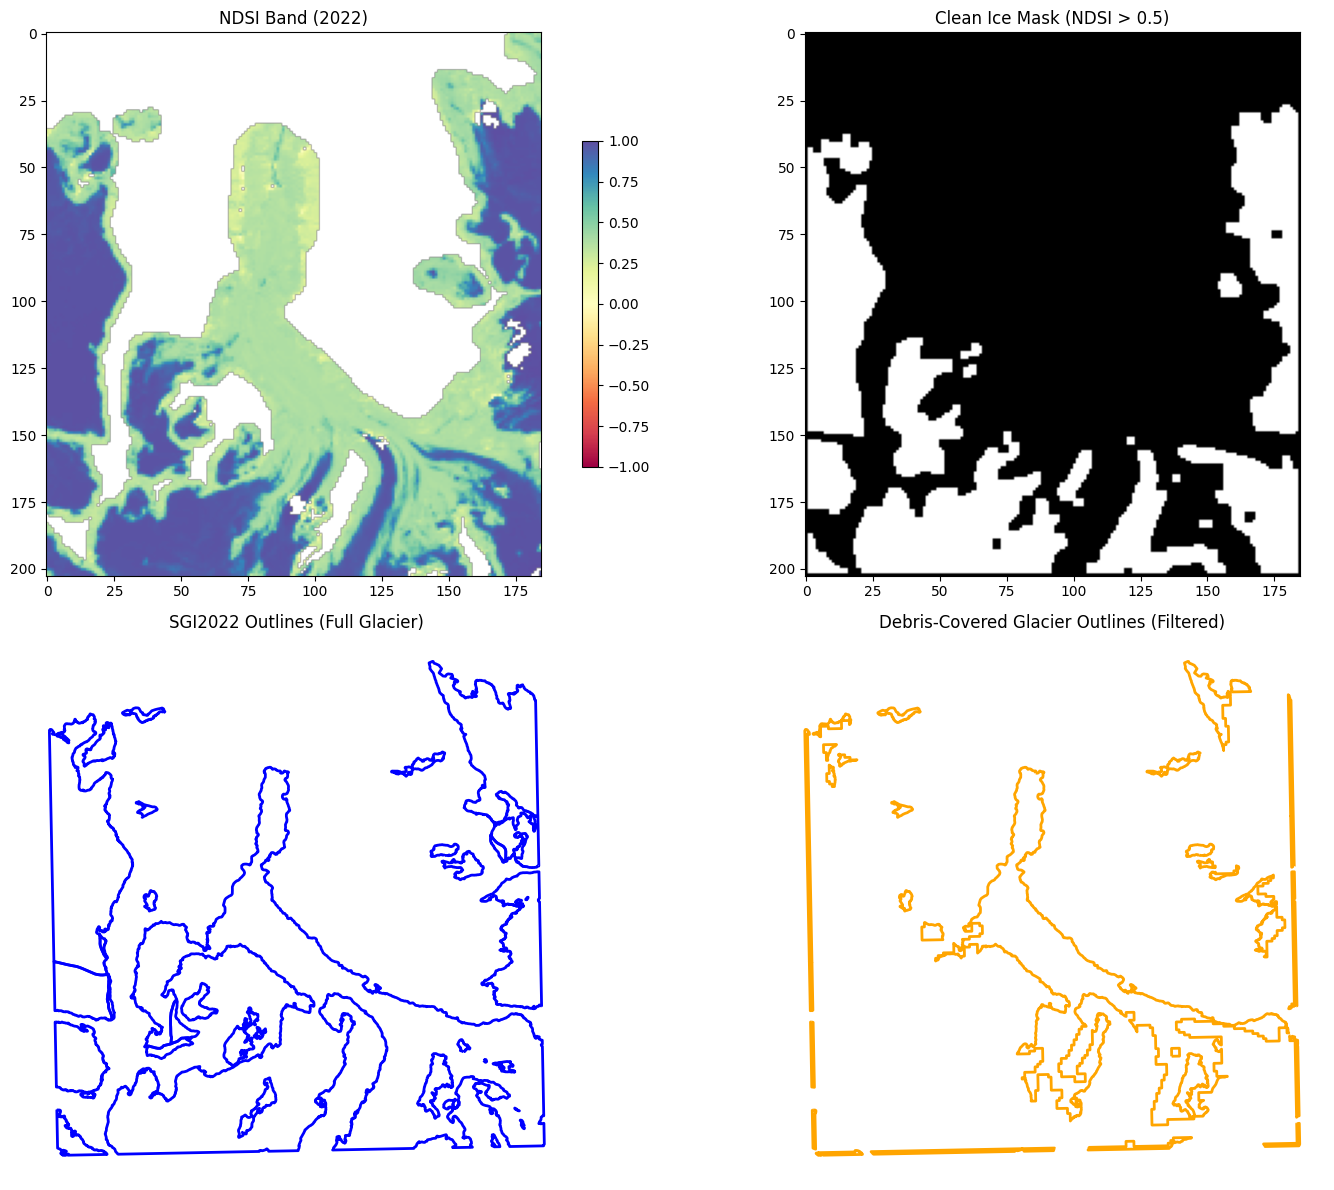

In [135]:
from shapely.geometry import shape, Polygon, MultiPolygon
from rasterio.features import shapes
from skimage.morphology import remove_small_objects, remove_small_holes
from skimage.measure import label as sk_label
from scipy.ndimage import binary_opening, binary_closing
import geopandas as gpd
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import numpy as np

# === 1. Extract NDSI band (band index 6, i.e. 7th band) ===
ndsi_band = image_data[test_glacier][2022][..., band_indices['ndsi']]

# === 2. Create binary clean ice mask (NDSI > threshold) ===
ndsi_threshold = 0.5
clean_ice_mask = ndsi_band > ndsi_threshold

# === 3. Morphological cleanup of mask ===
# Remove small objects and holes
clean_ice_mask = remove_small_objects(sk_label(clean_ice_mask), min_size=20)
clean_ice_mask = remove_small_holes(clean_ice_mask, area_threshold=20)

# Final smoothing (binary opening + closing)
clean_ice_mask = binary_opening(clean_ice_mask, structure=np.ones((3, 3)))
clean_ice_mask = binary_closing(clean_ice_mask, structure=np.ones((3, 3)))

# Ensure mask is uint8 for vectorization
clean_ice_mask = clean_ice_mask.astype(np.uint8)

# === 4. Vectorize clean ice mask and reproject ===
shapes_gen = shapes(clean_ice_mask, transform=binary_meta['transform'])

# Create raw geometry from shapes
clean_ice_polys = [shape(geom) for geom, val in shapes_gen if val == 1]

# Build GeoDataFrame from geometries, using original raster CRS
clean_ice_gdf = gpd.GeoDataFrame(geometry=clean_ice_polys, crs=binary_meta['crs'])

# Reproject to match glacier outlines
if clean_ice_gdf.crs != gdf_gt_clipped.crs:
    clean_ice_gdf = clean_ice_gdf.to_crs(gdf_gt_clipped.crs)

# Merge polygons into single union geometry
clean_ice_union = clean_ice_gdf.unary_union

# === 5. Subtract clean ice polygons from SGI2022 outlines ===
# Ensure same CRS
if gdf_gt_clipped.crs != "EPSG:2056":
    gdf_gt_clipped = gdf_gt_clipped.to_crs("EPSG:2056")

# Create GeoSeries of subtracted polygons
gt_dcg_geometry = gdf_gt_clipped.geometry.map(lambda geom: geom.difference(clean_ice_union))

# Build GeoDataFrame
gdf_dcg = gpd.GeoDataFrame(geometry=gt_dcg_geometry, crs=gdf_gt_clipped.crs)

# Remove empties and invalids
gdf_dcg = gdf_dcg[~gdf_dcg.is_empty & gdf_dcg.is_valid]

# Explode multipolygons
gdf_dcg = gdf_dcg.explode(index_parts=False).reset_index(drop=True)

# === 6. Area filtering ===
# Reproject if not already in EPSG:2056
if gdf_dcg.crs != "EPSG:2056":
    gdf_dcg = gdf_dcg.to_crs("EPSG:2056")

# Compute area
gdf_dcg["area"] = gdf_dcg.geometry.area

# Filter by area
min_area = 10*30*30  # m²
gdf_dcg_filtered = gdf_dcg[gdf_dcg["area"] >= min_area].copy()

# === DEBUGGING ===
print(f"Before filtering: {len(gdf_dcg)} polygons")
print(f"After filtering: {len(gdf_dcg_filtered)} polygons")
print("Filtered area range:", gdf_dcg_filtered['area'].min(), "-", gdf_dcg_filtered['area'].max())

# === 7. Plotting ===
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# NDSI image
ndsi_plot = axs[0, 0].imshow(ndsi_band, cmap='Spectral', vmin=-1, vmax=1)
axs[0, 0].set_title("NDSI Band (2022)")
fig.colorbar(ndsi_plot, ax=axs[0, 0], shrink=0.6)

# NDSI mask
axs[0, 1].imshow(clean_ice_mask, cmap='gray')
axs[0, 1].set_title(f"Clean Ice Mask (NDSI > {ndsi_threshold})")

# SGI outlines
gdf_gt_clipped.plot(ax=axs[1, 0], edgecolor='blue', facecolor='none', linewidth=2)
axs[1, 0].set_title("SGI2022 Outlines (Full Glacier)")
axs[1, 0].axis('off')

# DCG outlines
if not gdf_dcg_filtered.empty:
    gdf_dcg_filtered.plot(ax=axs[1, 1], edgecolor='orange', facecolor='none', linewidth=2)
axs[1, 1].set_title("Debris-Covered Glacier Outlines (Filtered)")
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()


/tmp/ipython-input-136-239990401.py:21: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  clean_ice_mask = remove_small_holes(clean_ice_mask, area_threshold=20)
/tmp/ipython-input-136-239990401.py:44: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  clean_ice_union = clean_ice_gdf.unary_union


Before filtering: 189 polygons
After filtering: 9 polygons
Filtered area range: 46858.692317295616 - 2729684.393604156


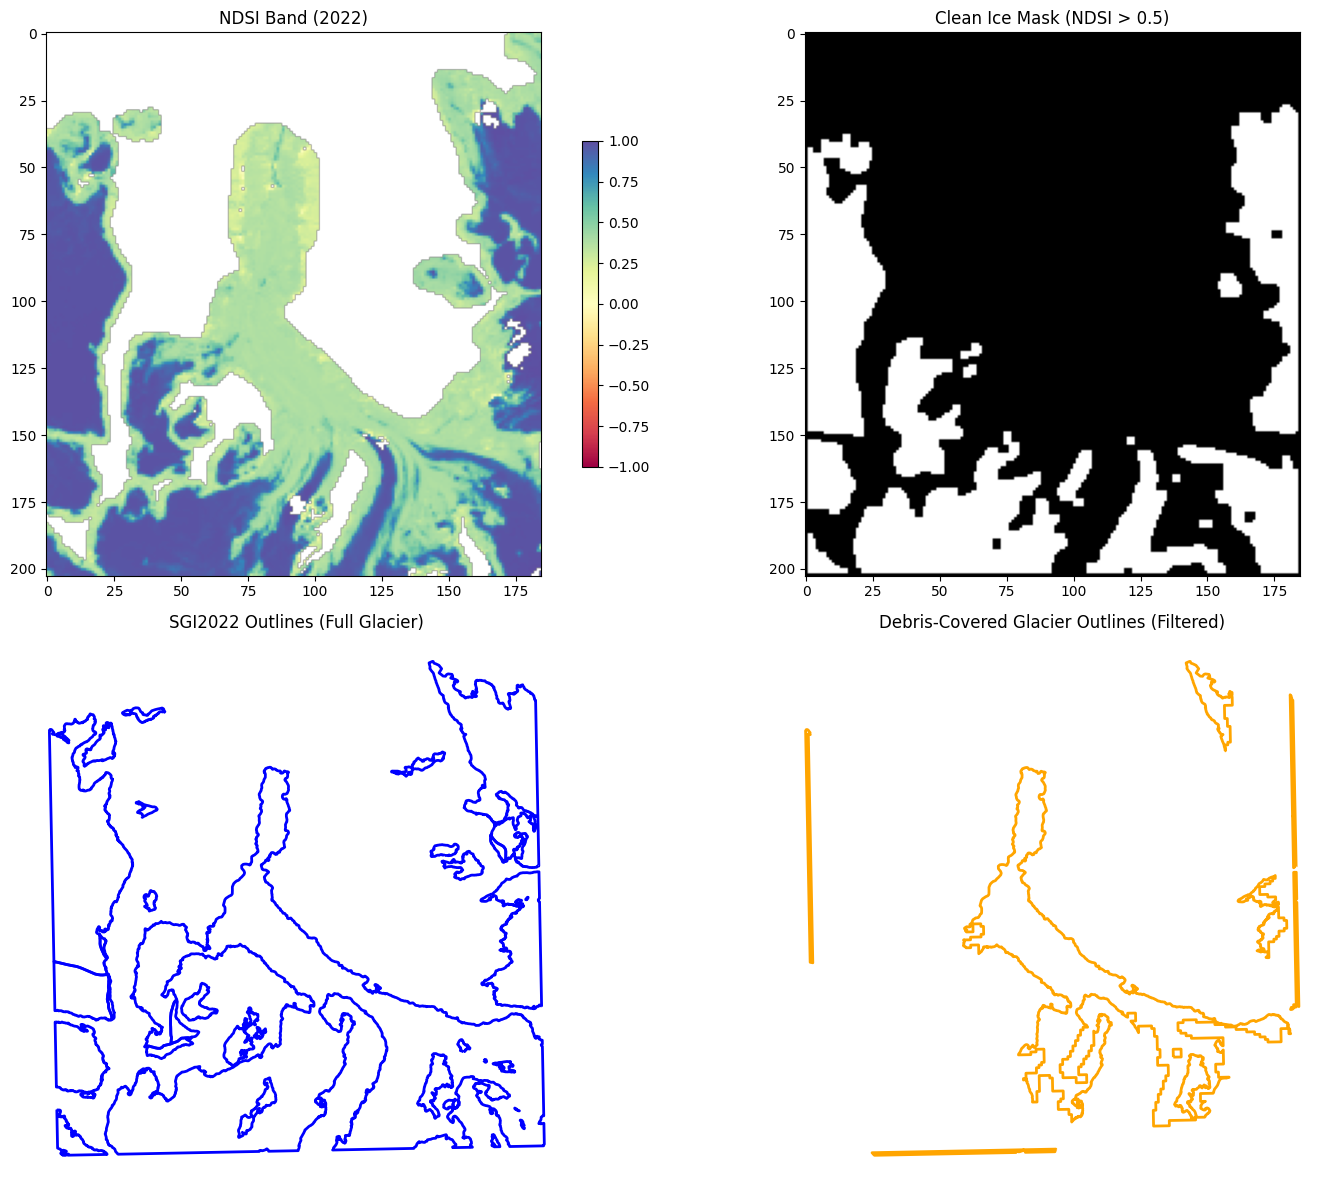

In [136]:
from shapely.geometry import shape, Polygon, MultiPolygon
from rasterio.features import shapes
from skimage.morphology import remove_small_objects, remove_small_holes
from skimage.measure import label as sk_label
from scipy.ndimage import binary_opening, binary_closing
import geopandas as gpd
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import numpy as np

# === 1. Extract NDSI band (band index 6, i.e. 7th band) ===
ndsi_band = image_data[test_glacier][2022][..., band_indices['ndsi']]

# === 2. Create binary clean ice mask (NDSI > threshold) ===
ndsi_threshold = 0.5
clean_ice_mask = ndsi_band > ndsi_threshold

# === 3. Morphological cleanup of mask ===
# Remove small objects and holes
clean_ice_mask = remove_small_objects(sk_label(clean_ice_mask), min_size=20)
clean_ice_mask = remove_small_holes(clean_ice_mask, area_threshold=20)

# Final smoothing (binary opening + closing)
clean_ice_mask = binary_opening(clean_ice_mask, structure=np.ones((3, 3)))
clean_ice_mask = binary_closing(clean_ice_mask, structure=np.ones((3, 3)))

# Ensure mask is uint8 for vectorization
clean_ice_mask = clean_ice_mask.astype(np.uint8)

# === 4. Vectorize clean ice mask and reproject ===
shapes_gen = shapes(clean_ice_mask, transform=binary_meta['transform'])

# Create raw geometry from shapes
clean_ice_polys = [shape(geom) for geom, val in shapes_gen if val == 1]

# Build GeoDataFrame from geometries, using original raster CRS
clean_ice_gdf = gpd.GeoDataFrame(geometry=clean_ice_polys, crs=binary_meta['crs'])

# Reproject to match glacier outlines
if clean_ice_gdf.crs != gdf_gt_clipped.crs:
    clean_ice_gdf = clean_ice_gdf.to_crs(gdf_gt_clipped.crs)

# Merge polygons into single union geometry
clean_ice_union = clean_ice_gdf.unary_union

# === 5. Subtract clean ice polygons from SGI2022 outlines ===
# Ensure same CRS
if gdf_gt_clipped.crs != "EPSG:2056":
    gdf_gt_clipped = gdf_gt_clipped.to_crs("EPSG:2056")

# Create GeoSeries of subtracted polygons
gt_dcg_geometry = gdf_gt_clipped.geometry.map(lambda geom: geom.difference(clean_ice_union))

# Build GeoDataFrame
gdf_dcg = gpd.GeoDataFrame(geometry=gt_dcg_geometry, crs=gdf_gt_clipped.crs)

# Remove empties and invalids
gdf_dcg = gdf_dcg[~gdf_dcg.is_empty & gdf_dcg.is_valid]

# Explode multipolygons
gdf_dcg = gdf_dcg.explode(index_parts=False).reset_index(drop=True)

# === 6. Area filtering ===
# Reproject if not already in EPSG:2056
if gdf_dcg.crs != "EPSG:2056":
    gdf_dcg = gdf_dcg.to_crs("EPSG:2056")

# Compute area
gdf_dcg["area"] = gdf_dcg.geometry.area

# Filter by area
min_area = 50*30*30  # m²
gdf_dcg_filtered = gdf_dcg[gdf_dcg["area"] >= min_area].copy()

# === DEBUGGING ===
print(f"Before filtering: {len(gdf_dcg)} polygons")
print(f"After filtering: {len(gdf_dcg_filtered)} polygons")
print("Filtered area range:", gdf_dcg_filtered['area'].min(), "-", gdf_dcg_filtered['area'].max())

# === 7. Plotting ===
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# NDSI image
ndsi_plot = axs[0, 0].imshow(ndsi_band, cmap='Spectral', vmin=-1, vmax=1)
axs[0, 0].set_title("NDSI Band (2022)")
fig.colorbar(ndsi_plot, ax=axs[0, 0], shrink=0.6)

# NDSI mask
axs[0, 1].imshow(clean_ice_mask, cmap='gray')
axs[0, 1].set_title(f"Clean Ice Mask (NDSI > {ndsi_threshold})")

# SGI outlines
gdf_gt_clipped.plot(ax=axs[1, 0], edgecolor='blue', facecolor='none', linewidth=2)
axs[1, 0].set_title("SGI2022 Outlines (Full Glacier)")
axs[1, 0].axis('off')

# DCG outlines
if not gdf_dcg_filtered.empty:
    gdf_dcg_filtered.plot(ax=axs[1, 1], edgecolor='orange', facecolor='none', linewidth=2)
axs[1, 1].set_title("Debris-Covered Glacier Outlines (Filtered)")
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()


13. Compare permutation importance
---
Compare importance values across different glaciers and store the plots in a drive folder.

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


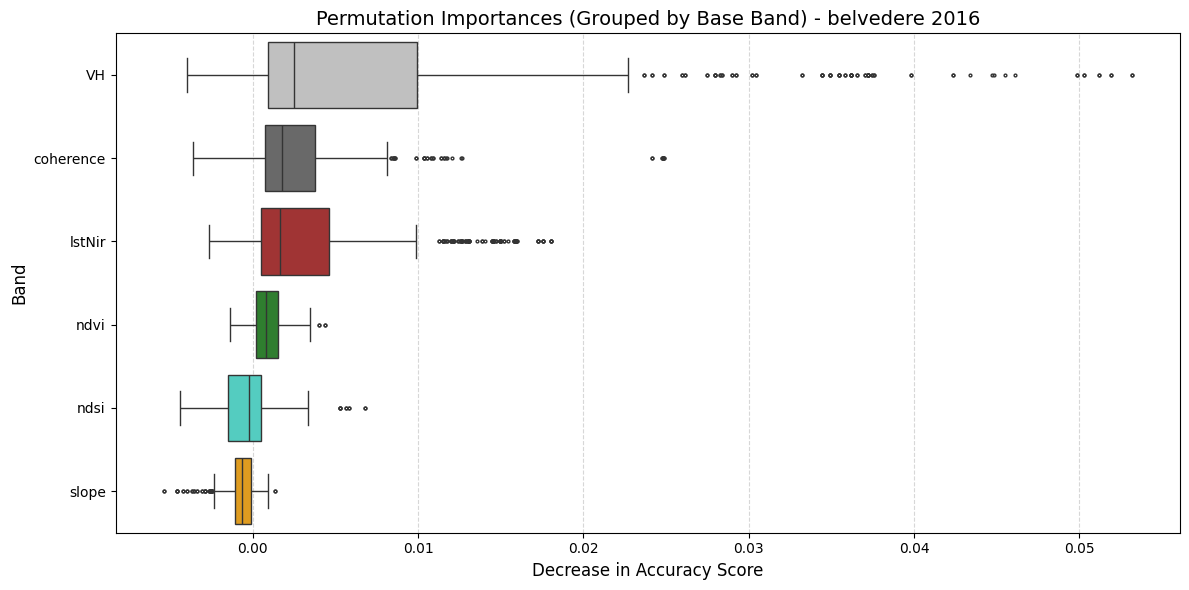

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


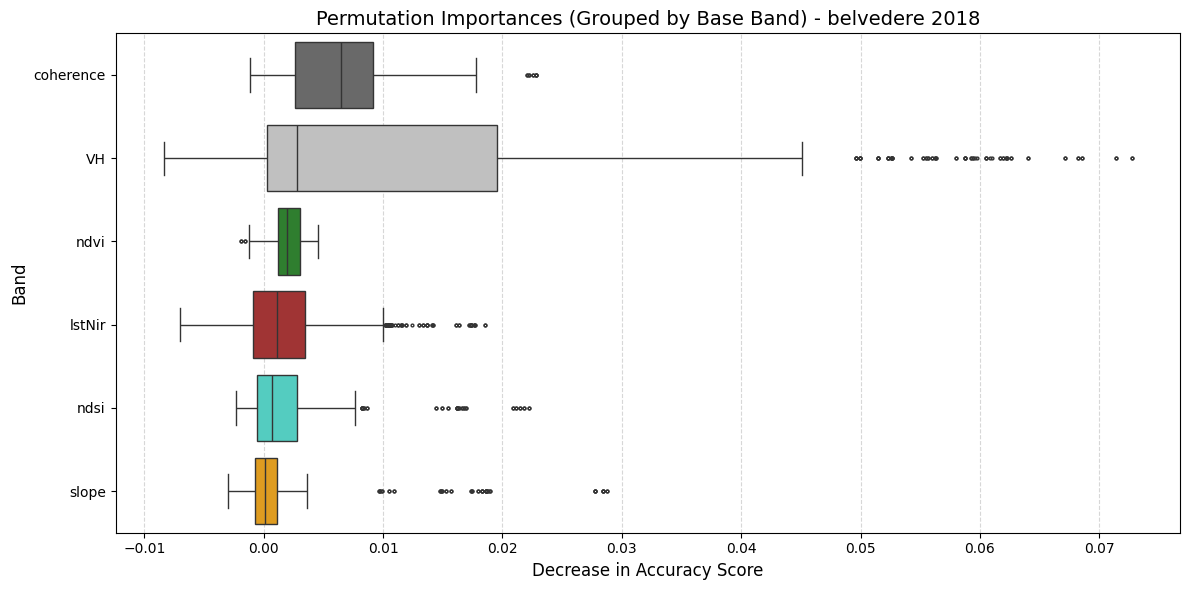

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


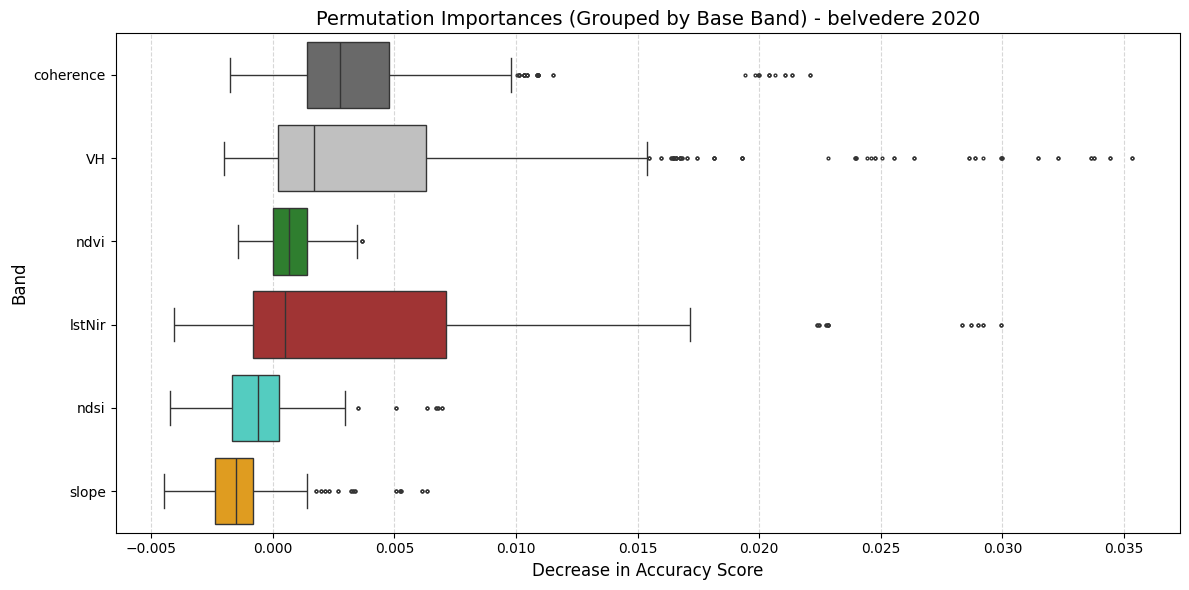

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


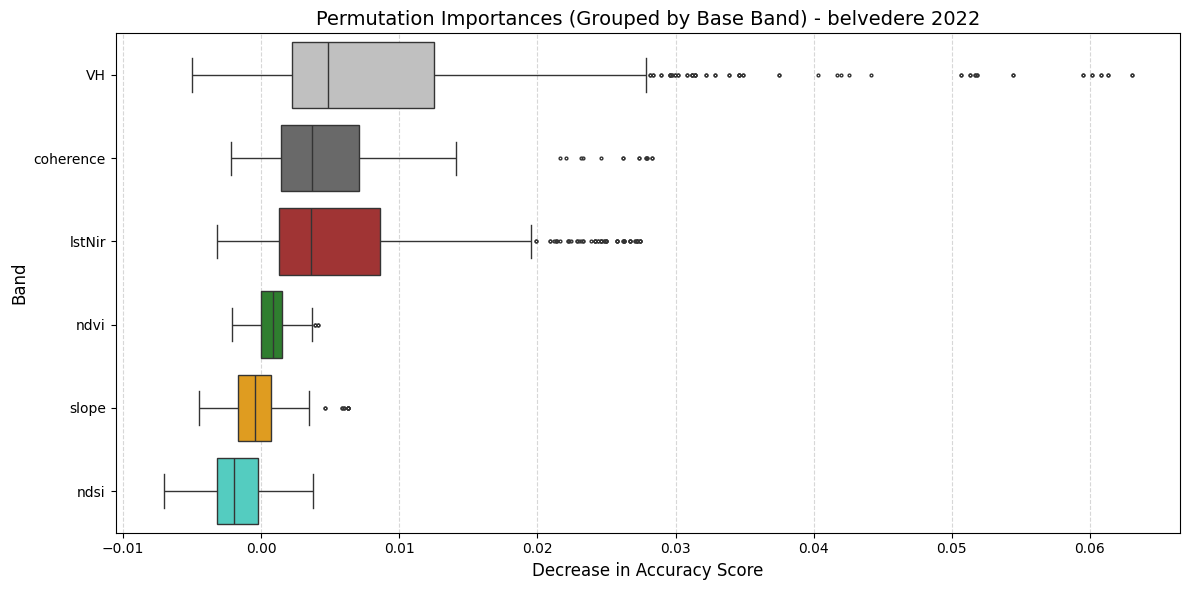

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


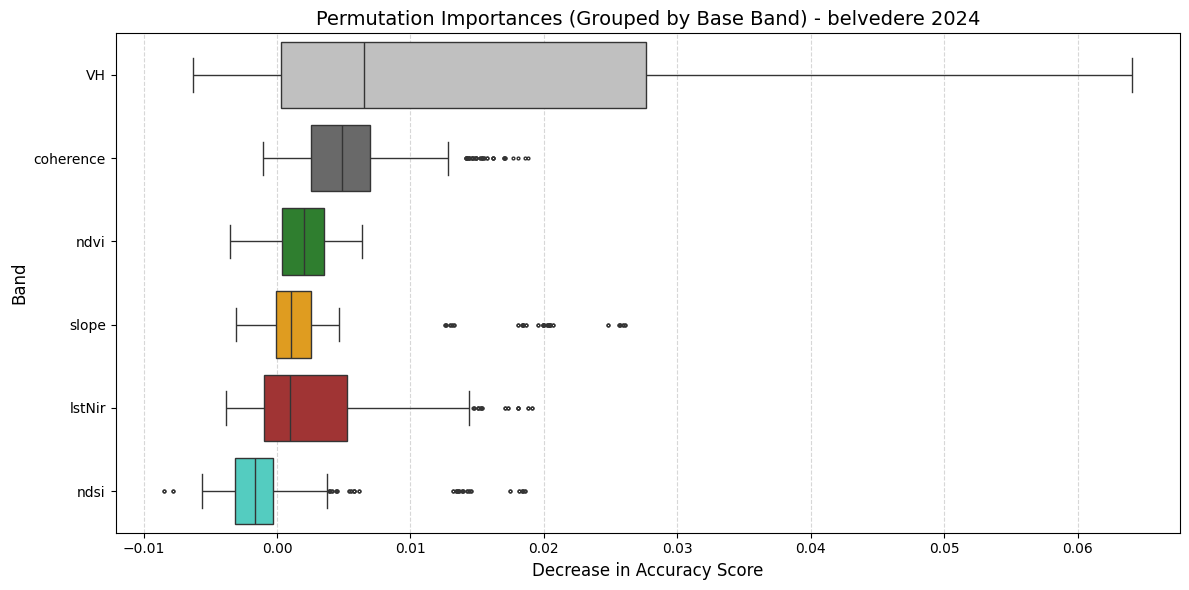

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


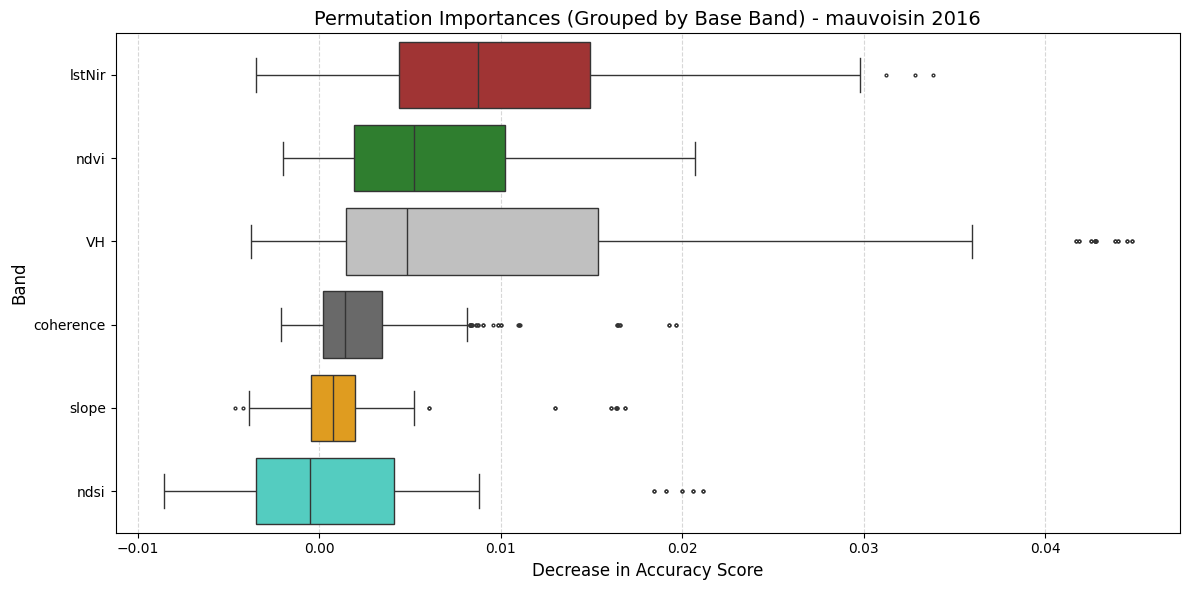

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


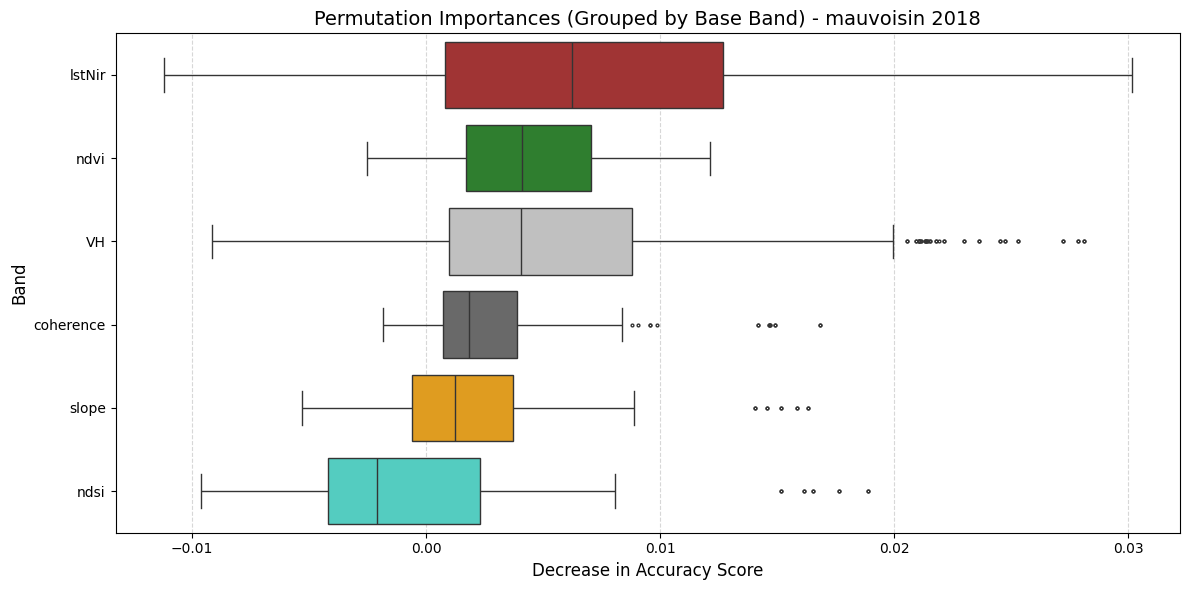

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


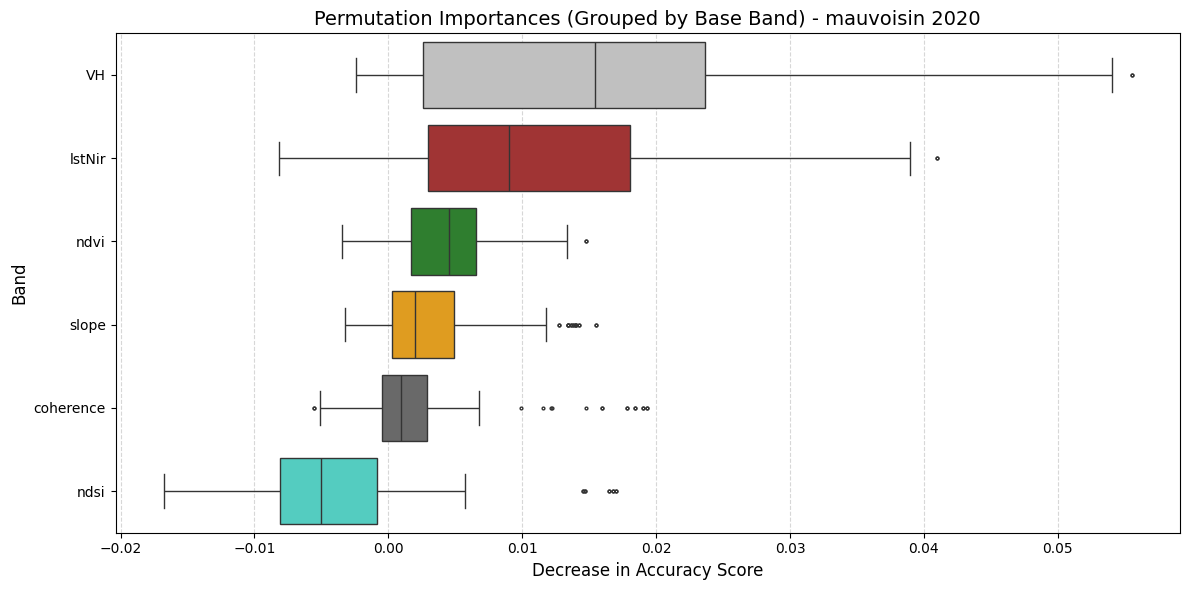

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


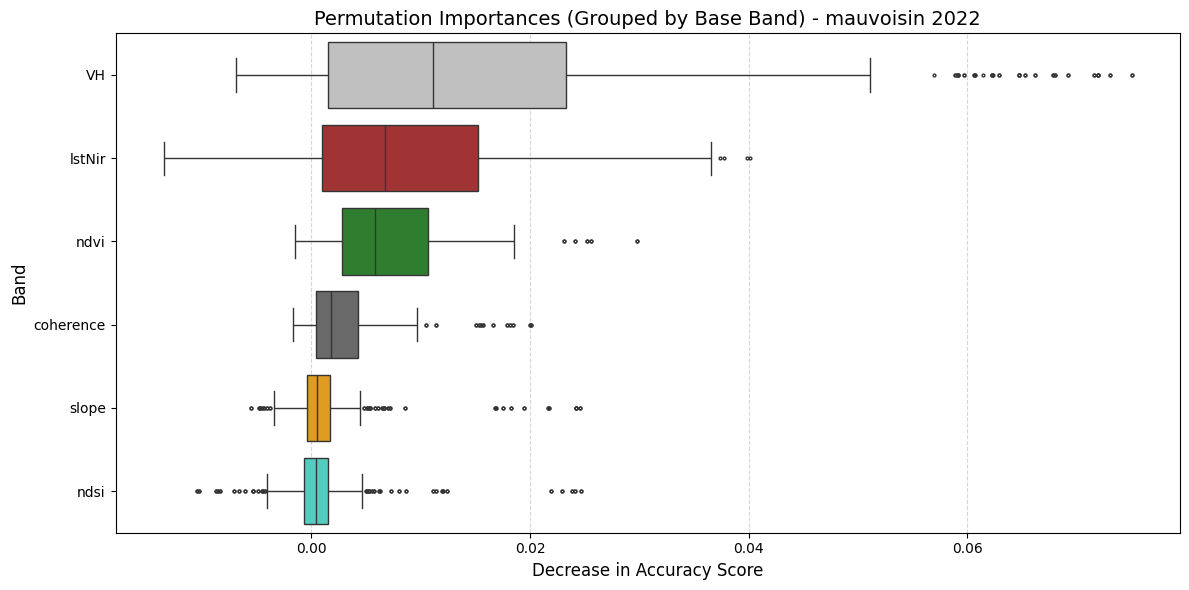

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


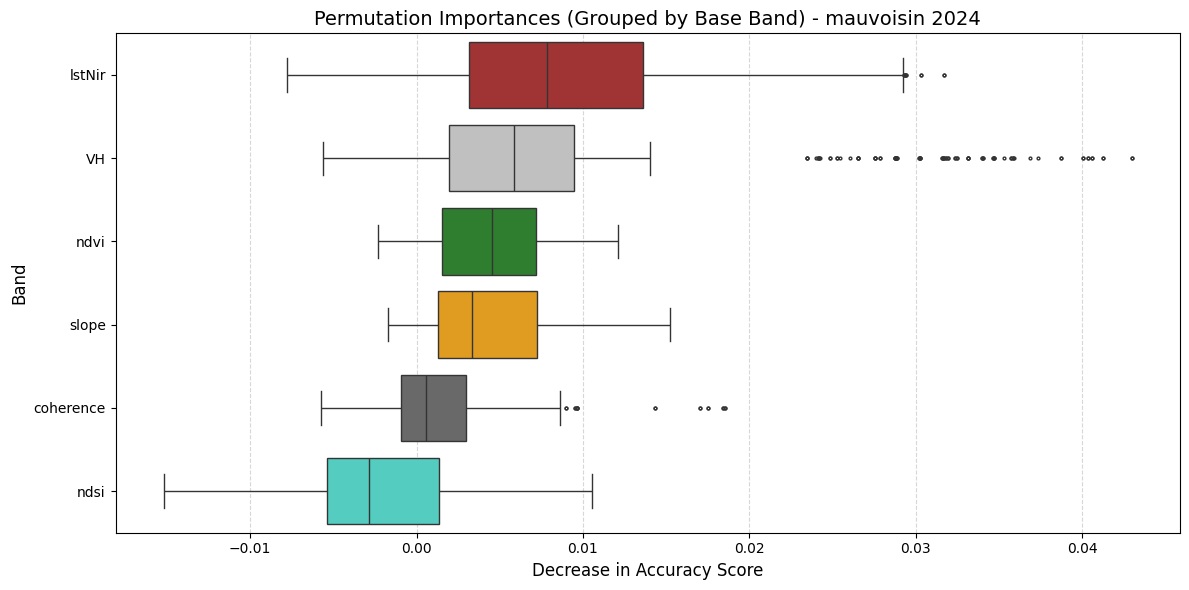

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


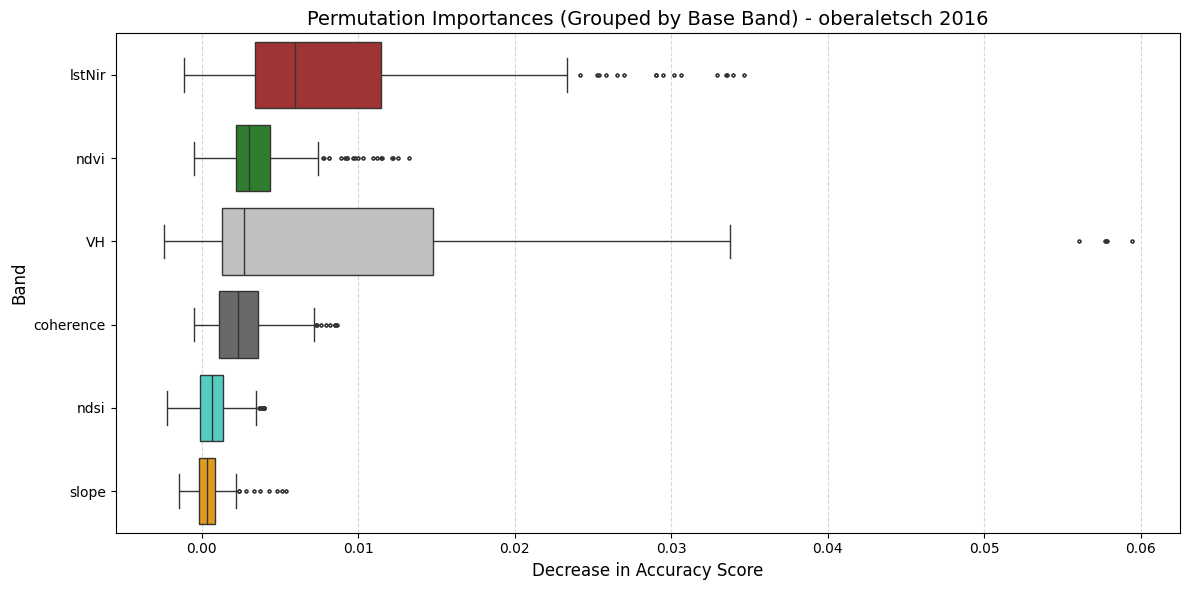

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


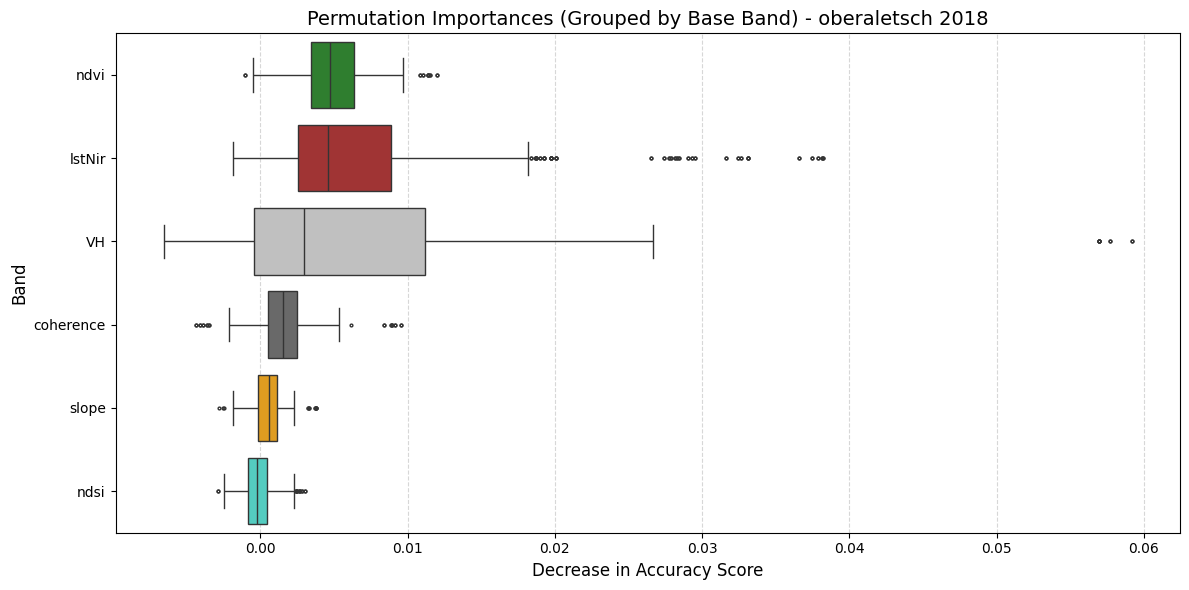

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


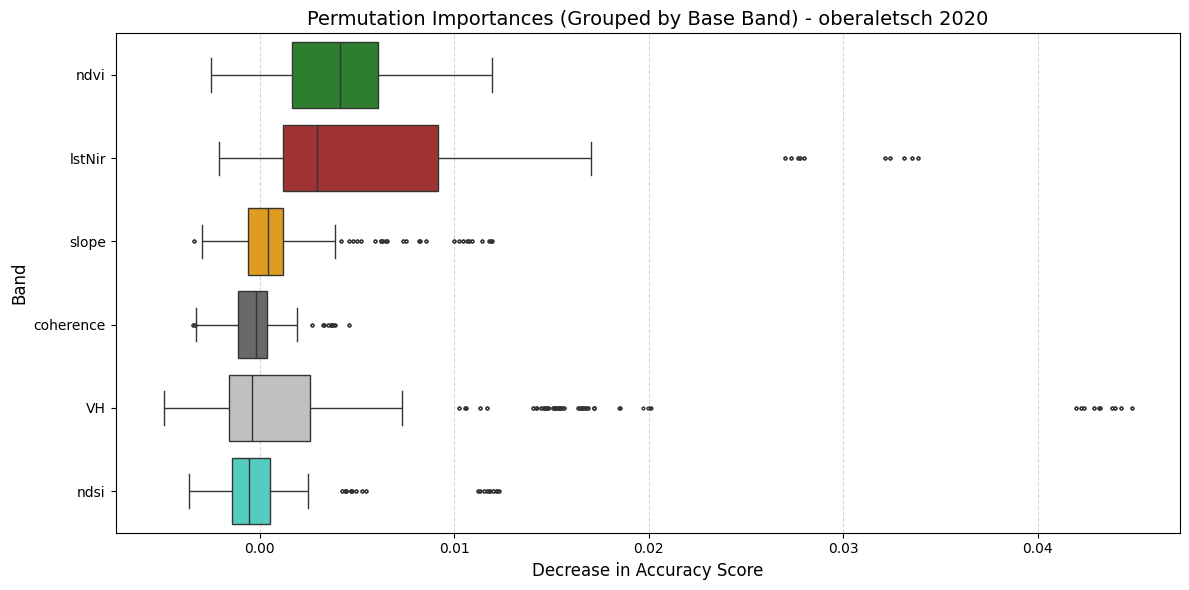

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


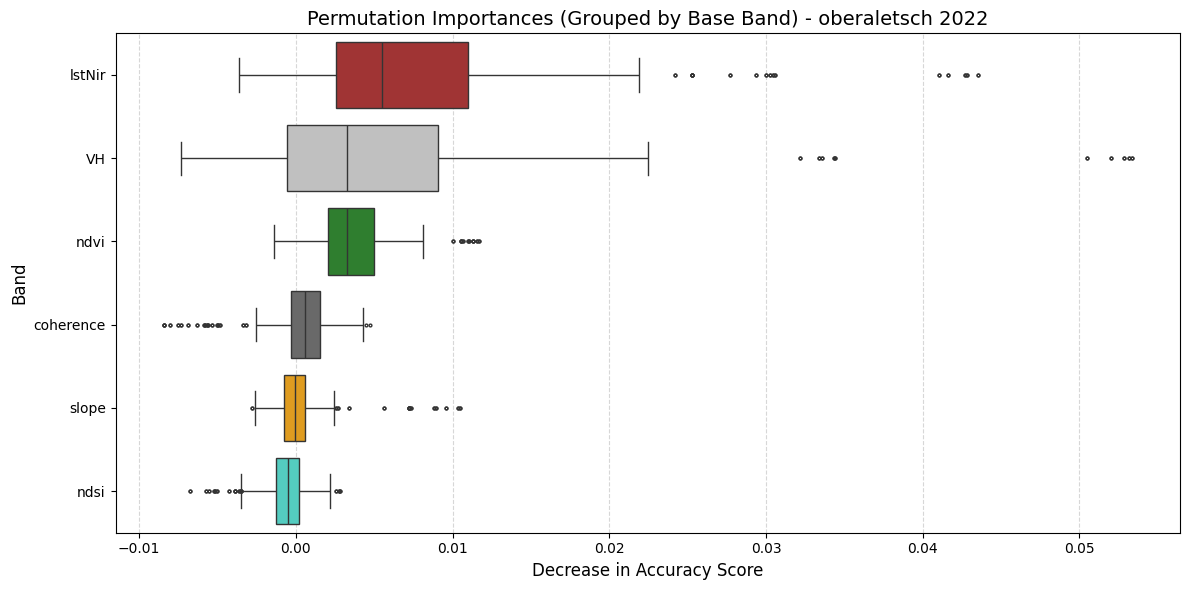

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


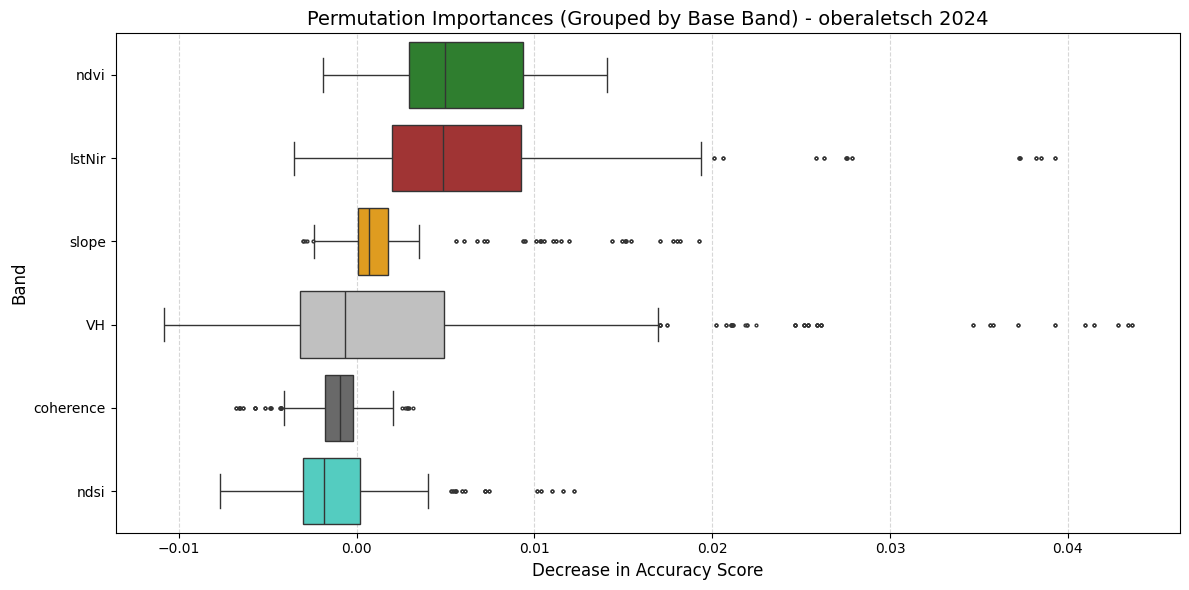

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


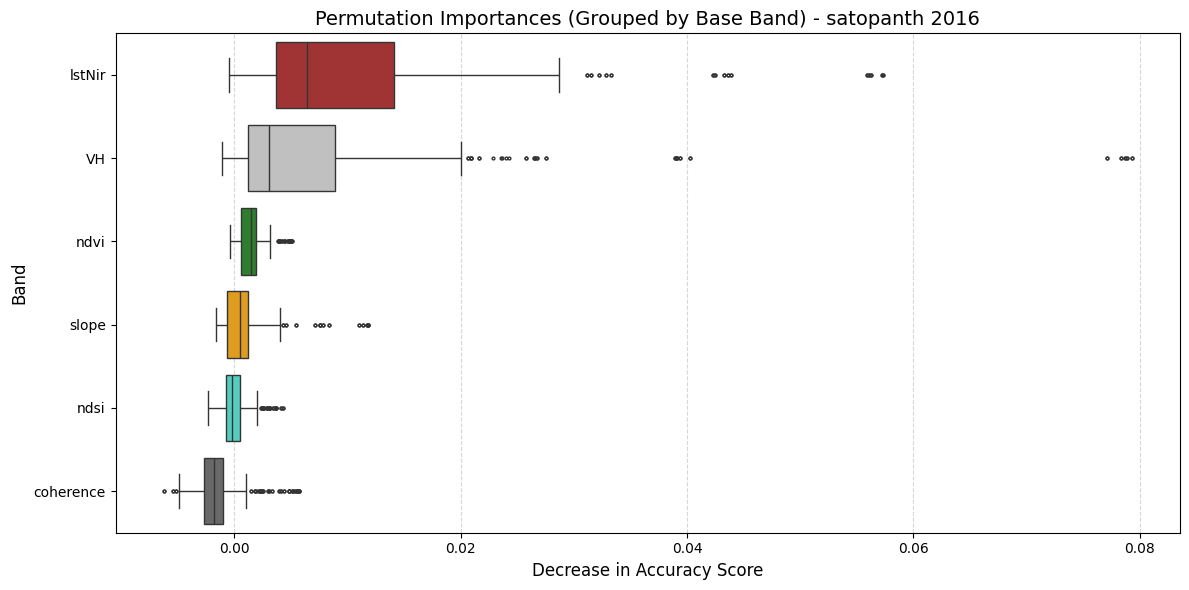

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


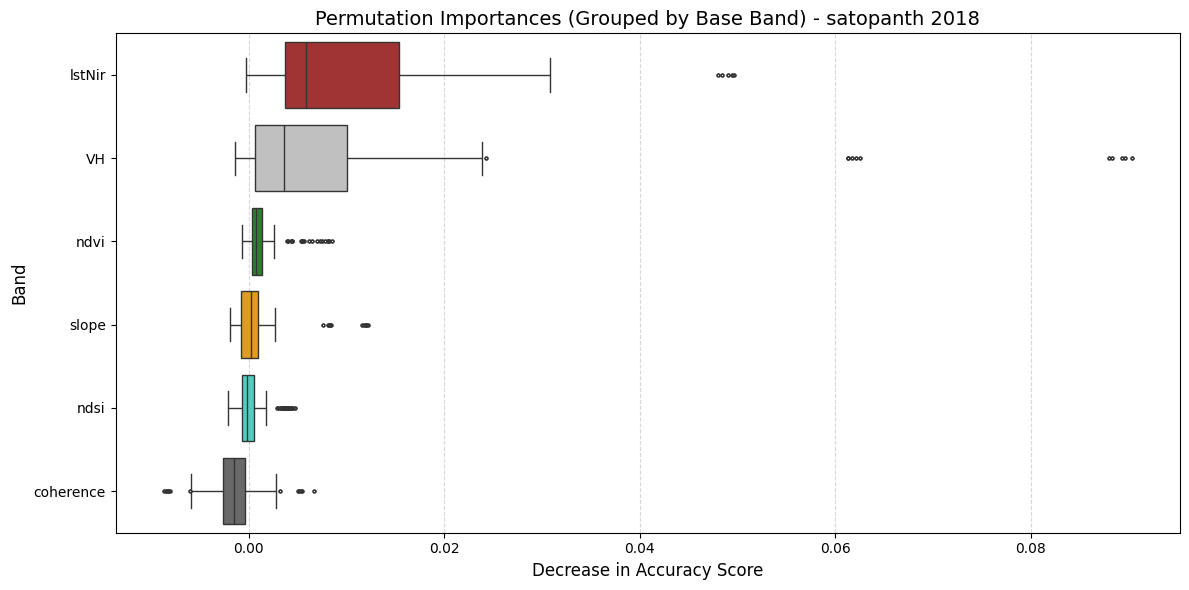

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


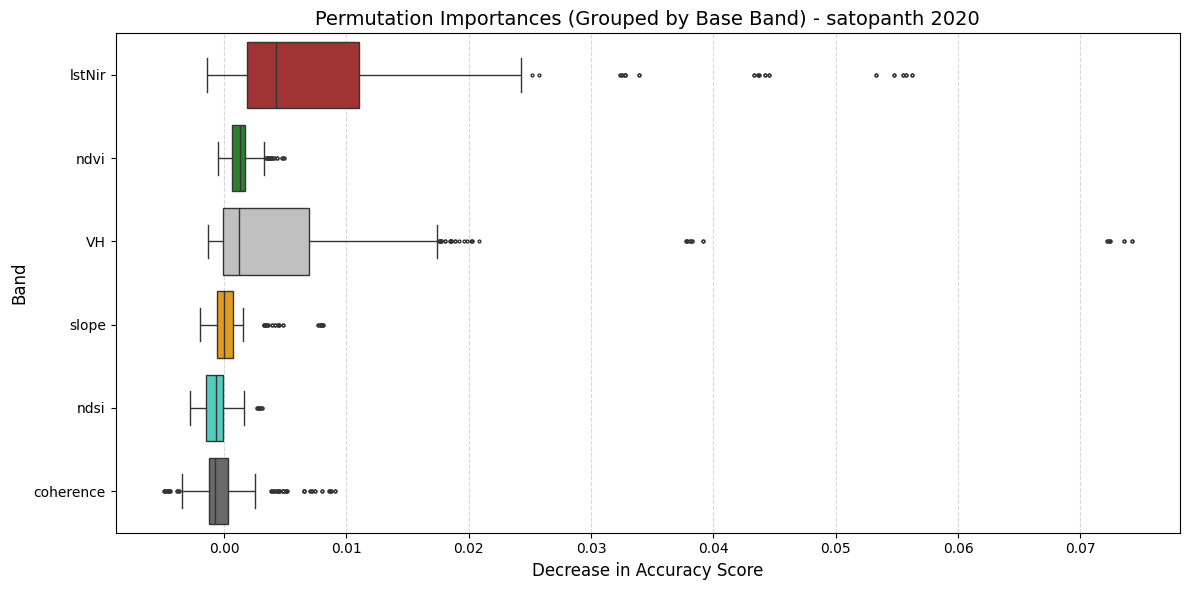

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


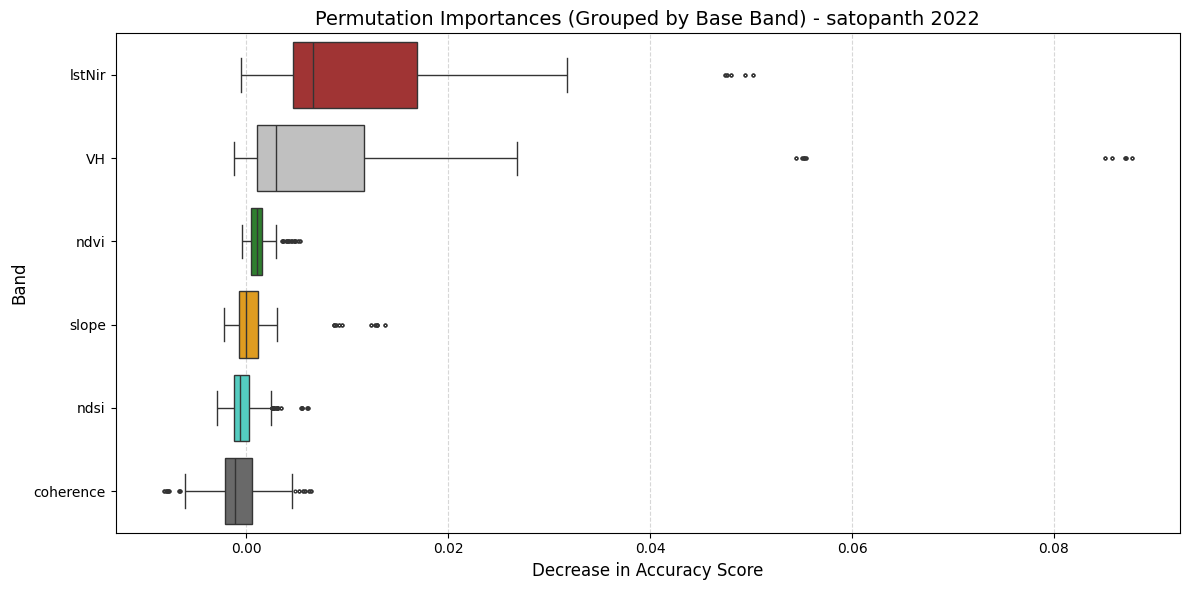

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


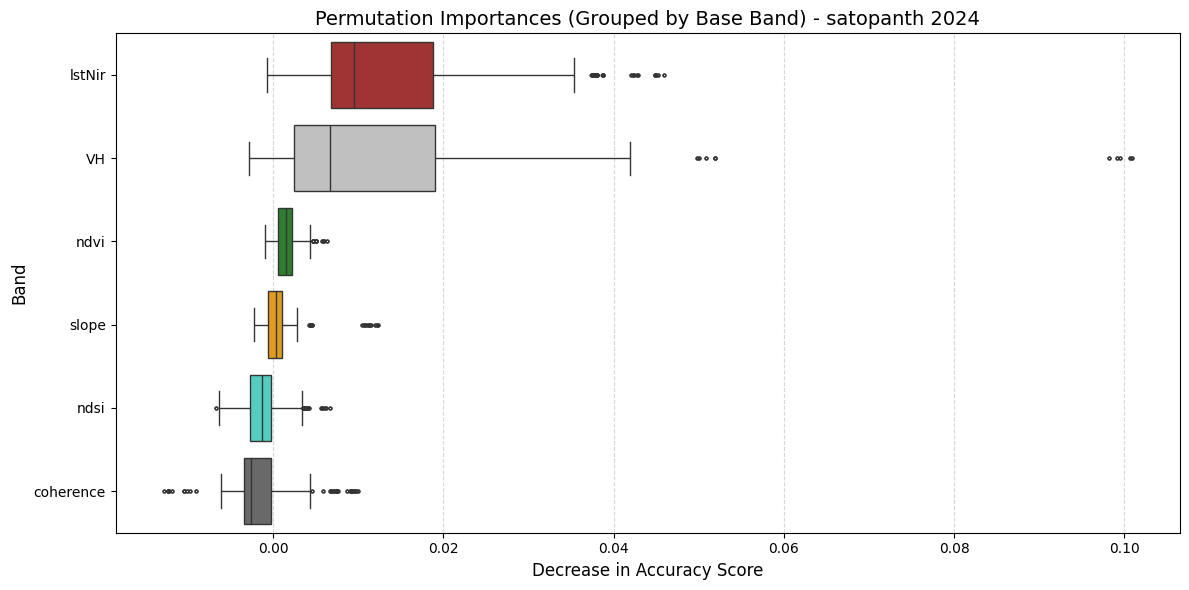

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


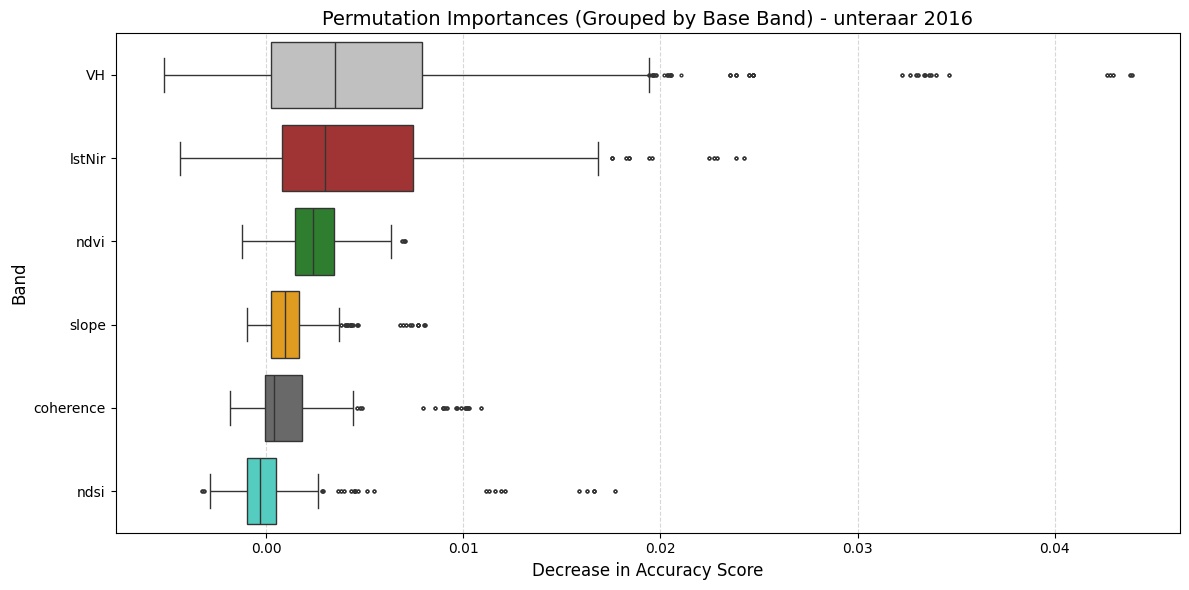

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


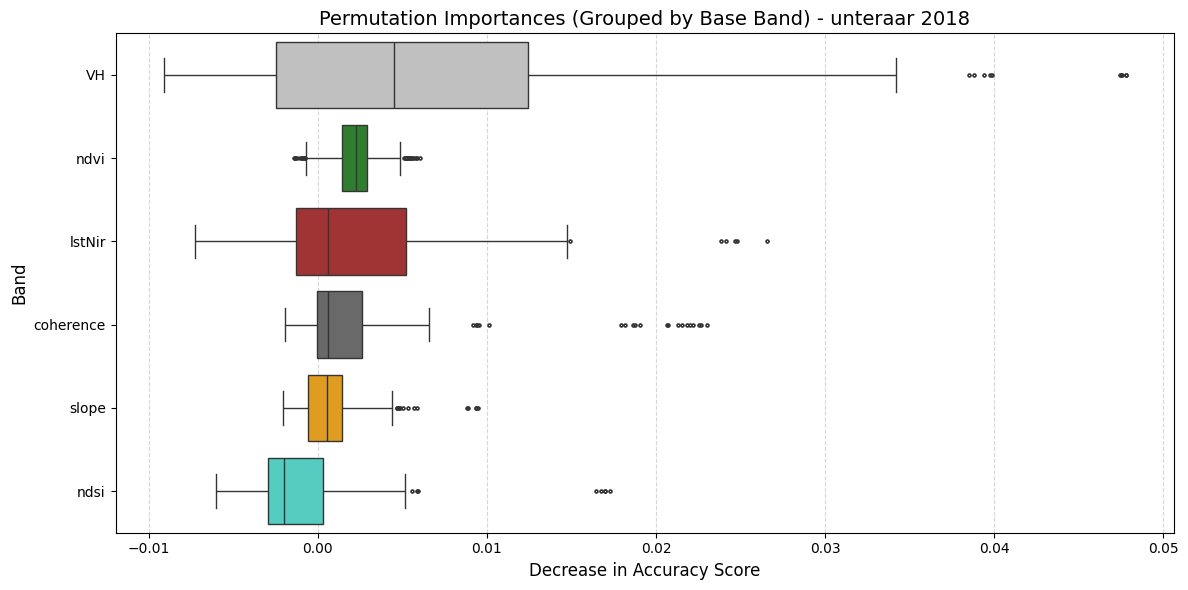

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


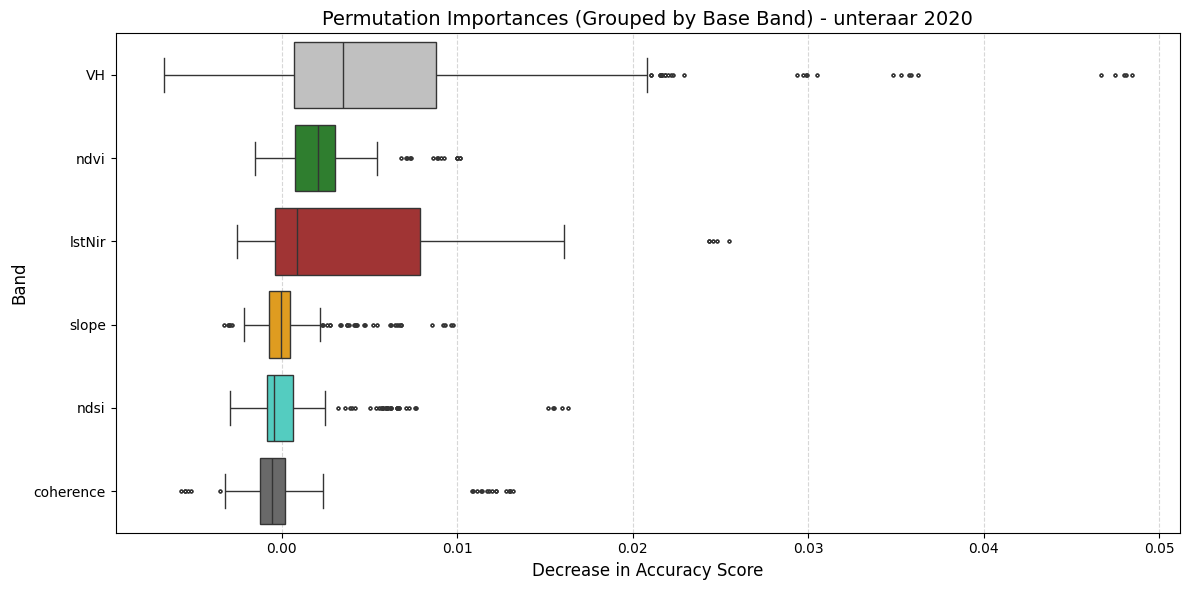

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


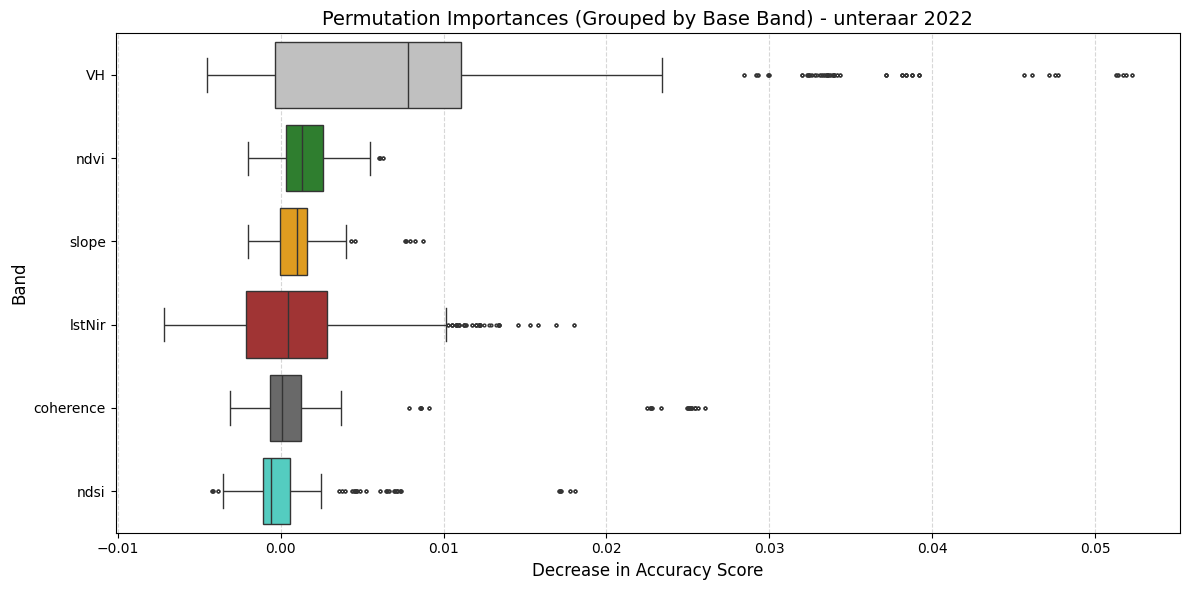

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


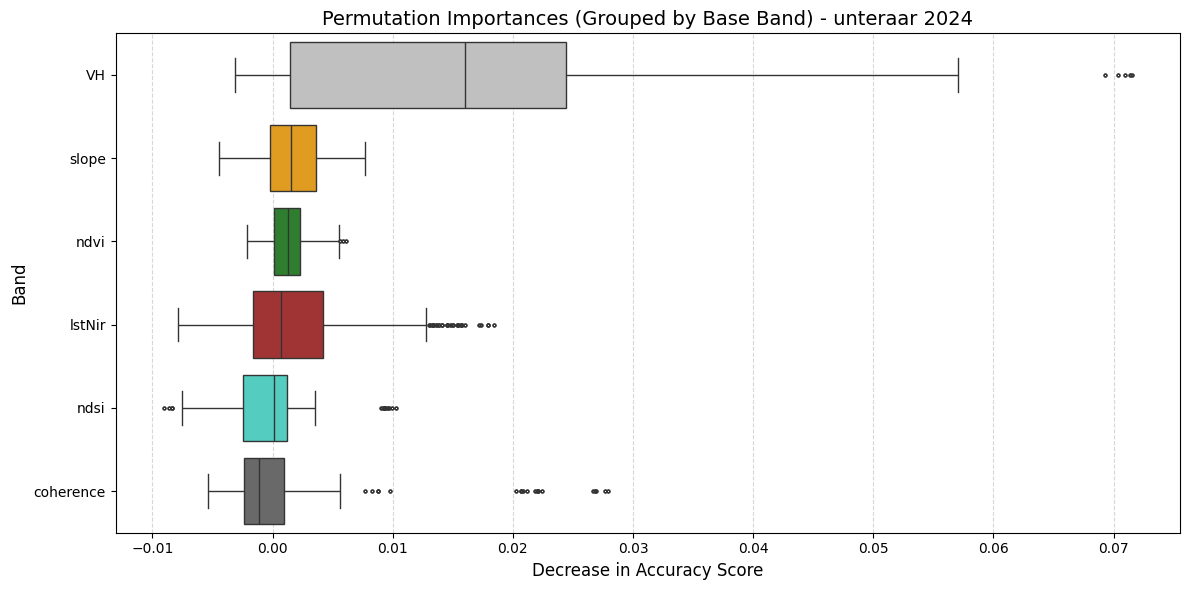

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


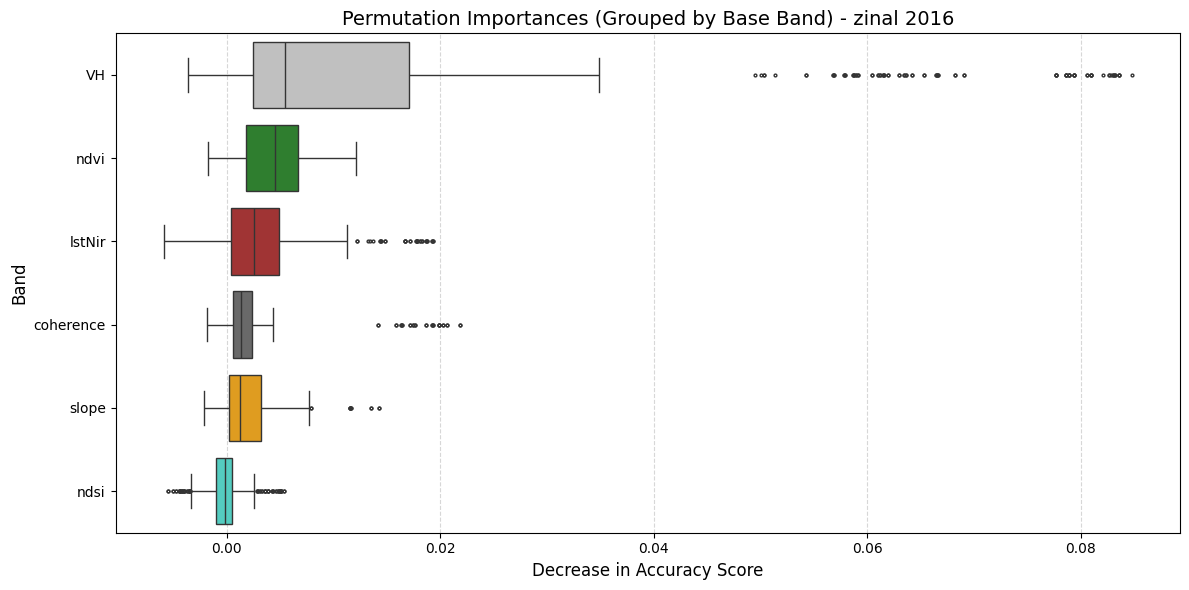

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


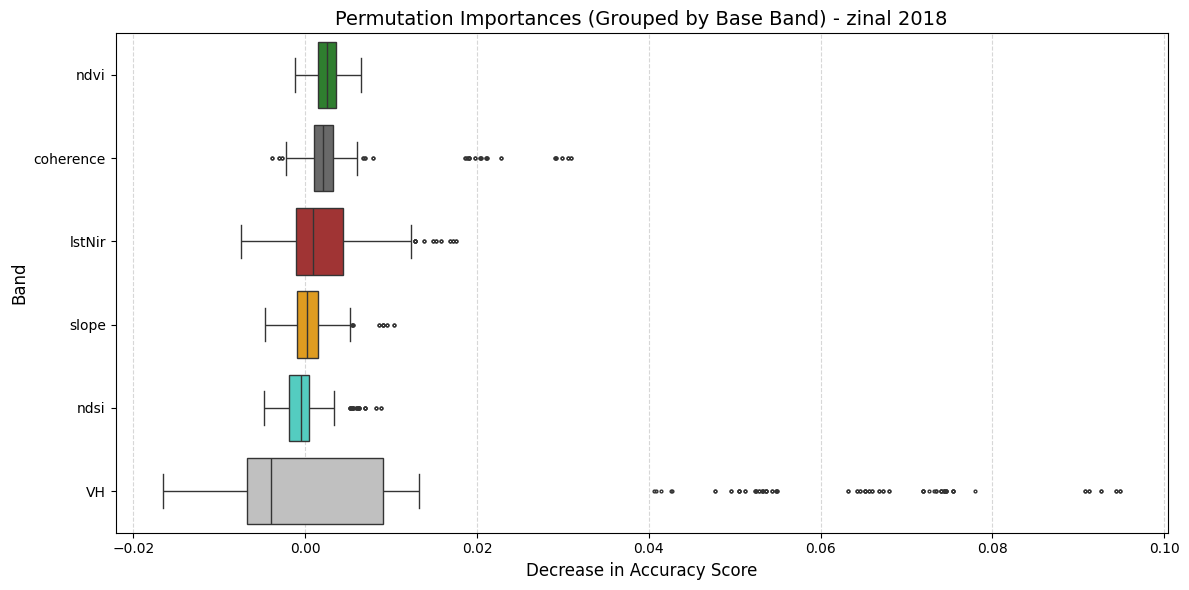

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


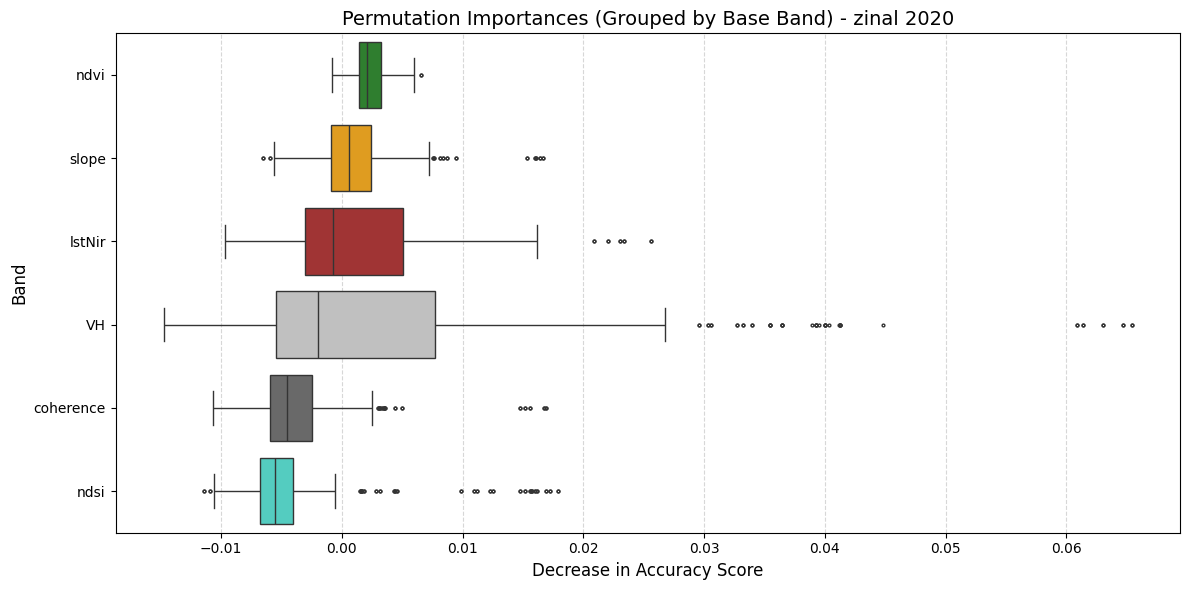

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


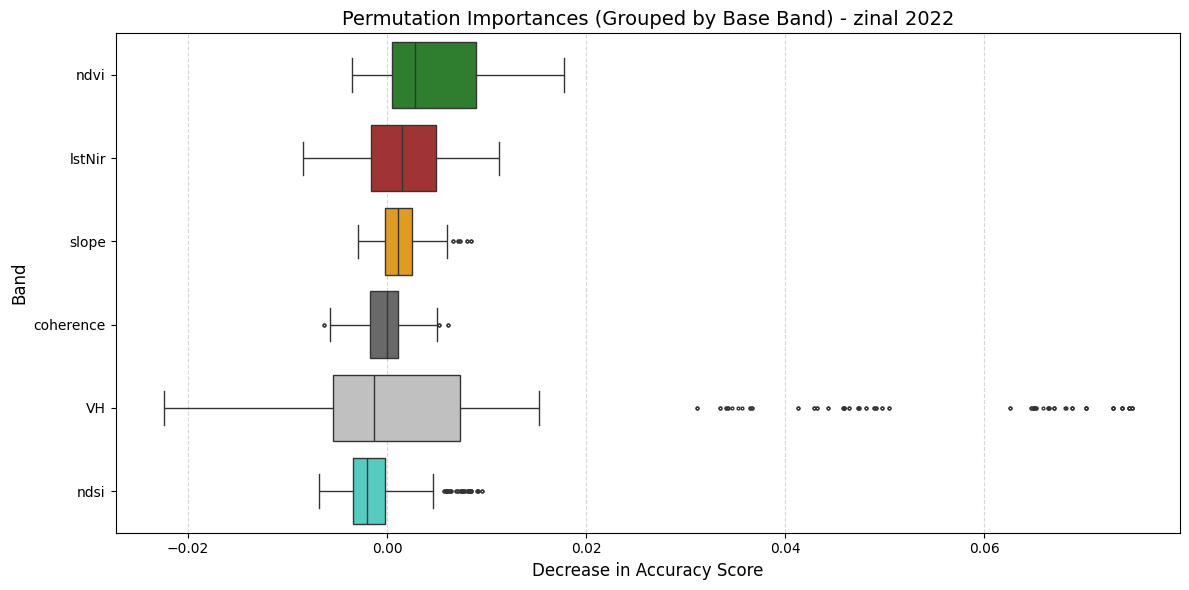

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


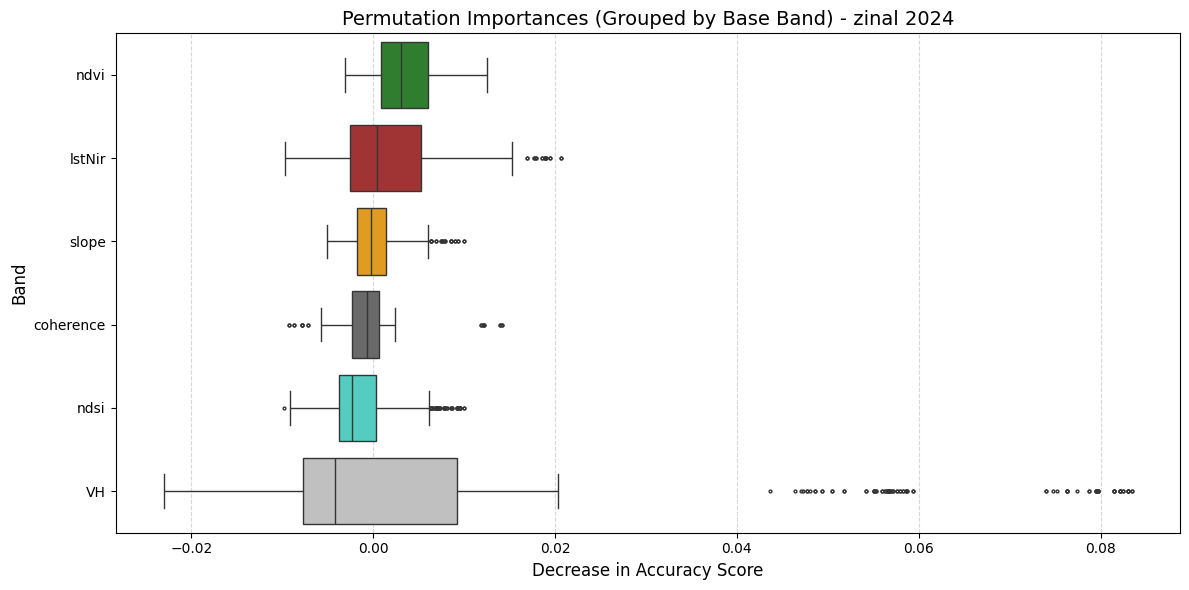

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


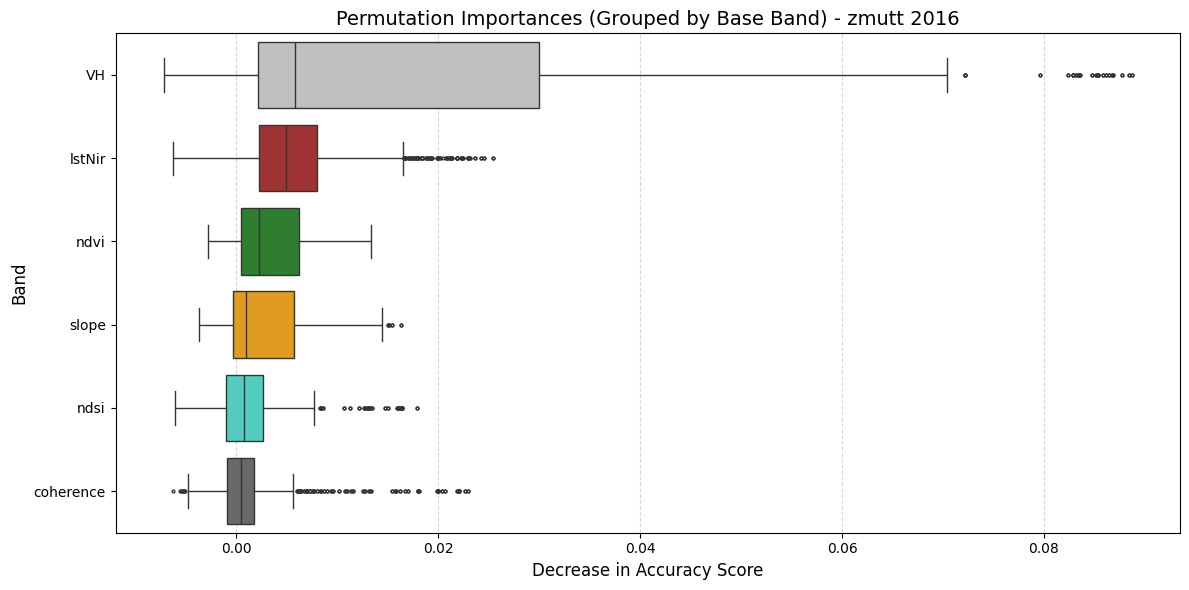

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


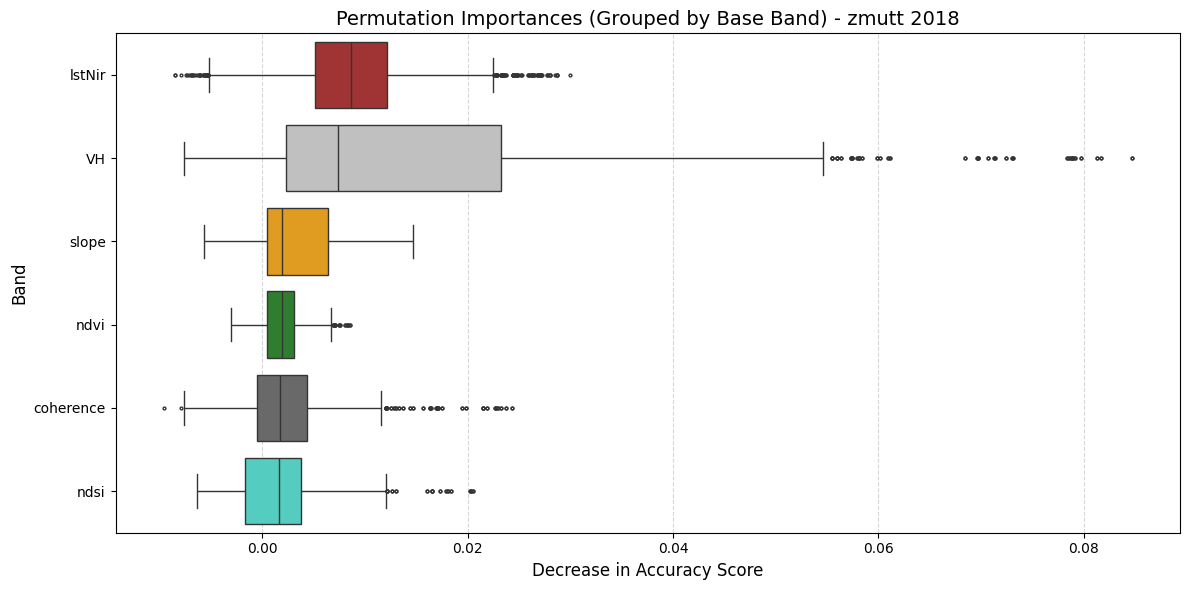

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


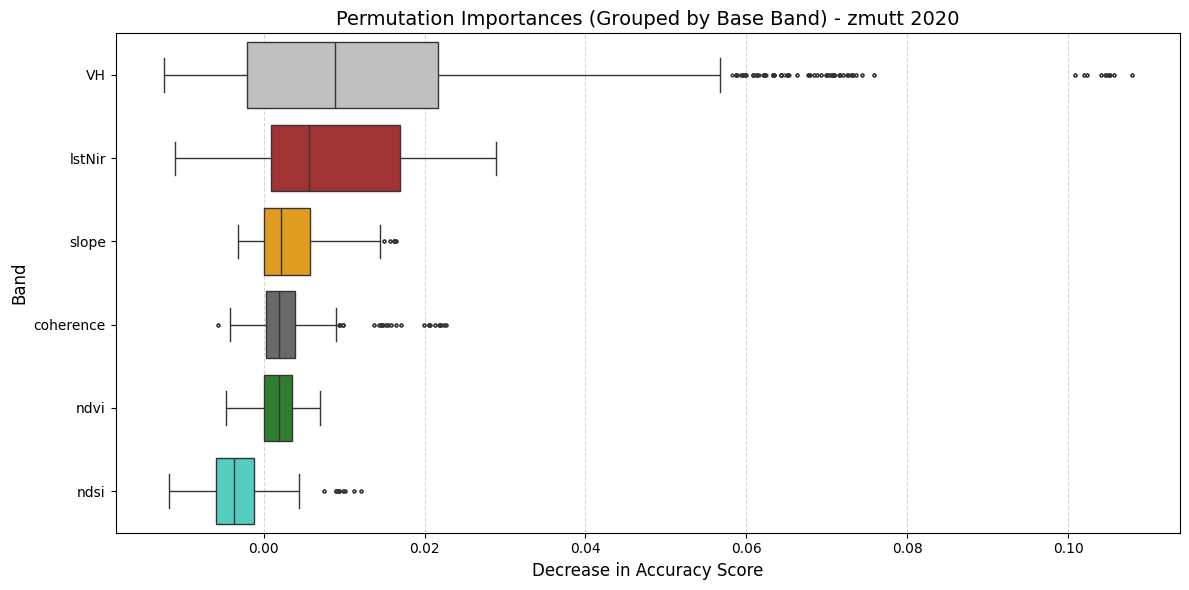

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


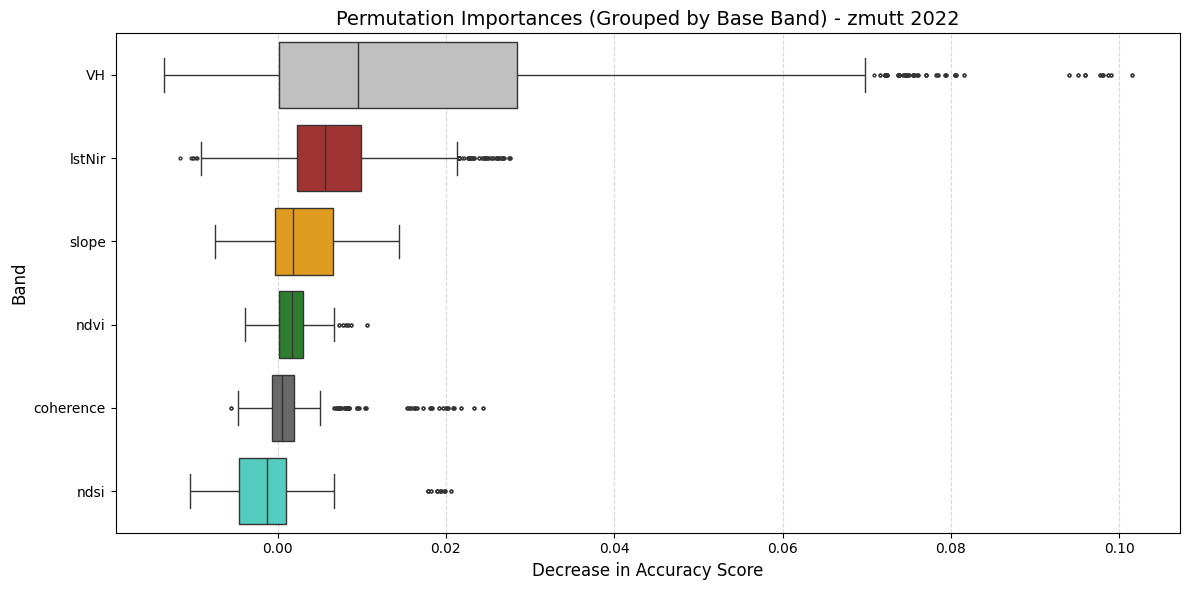

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


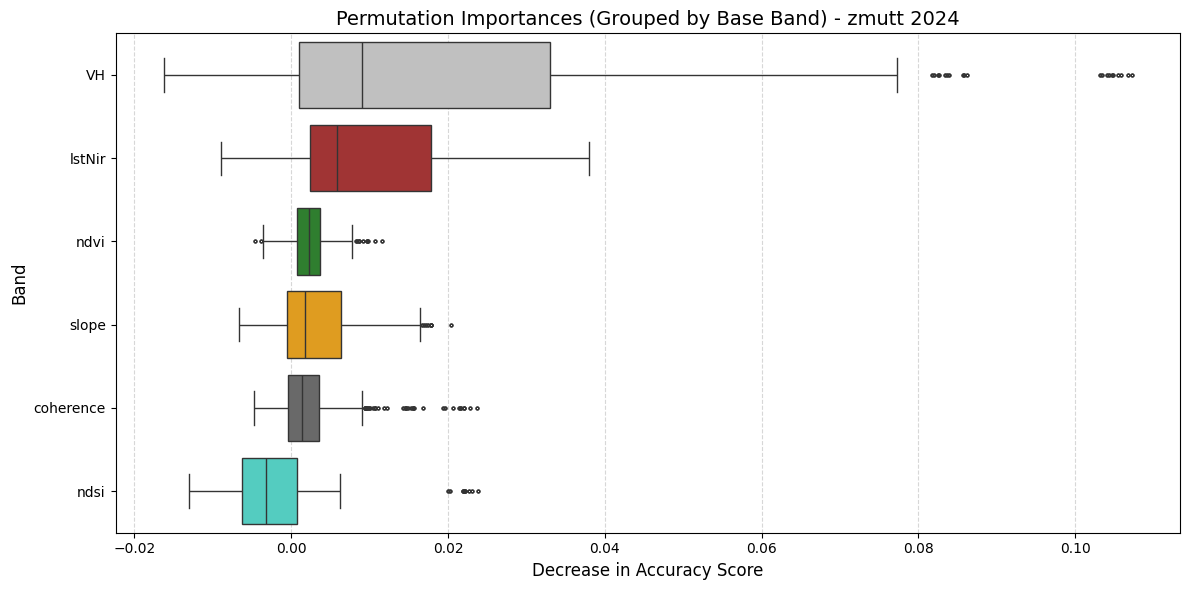

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


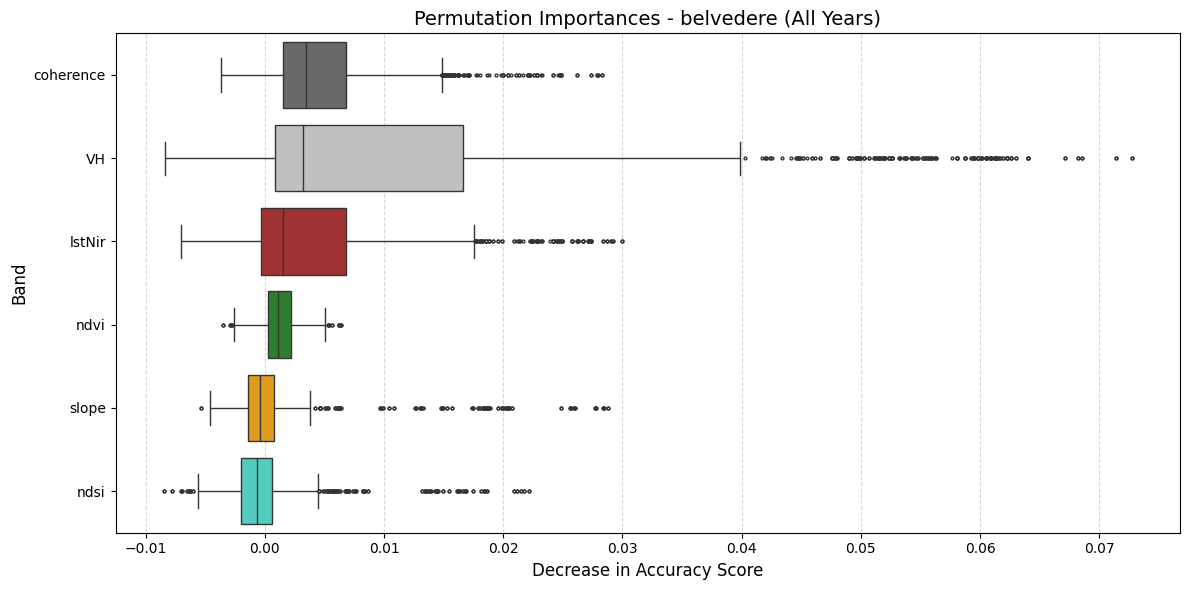

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


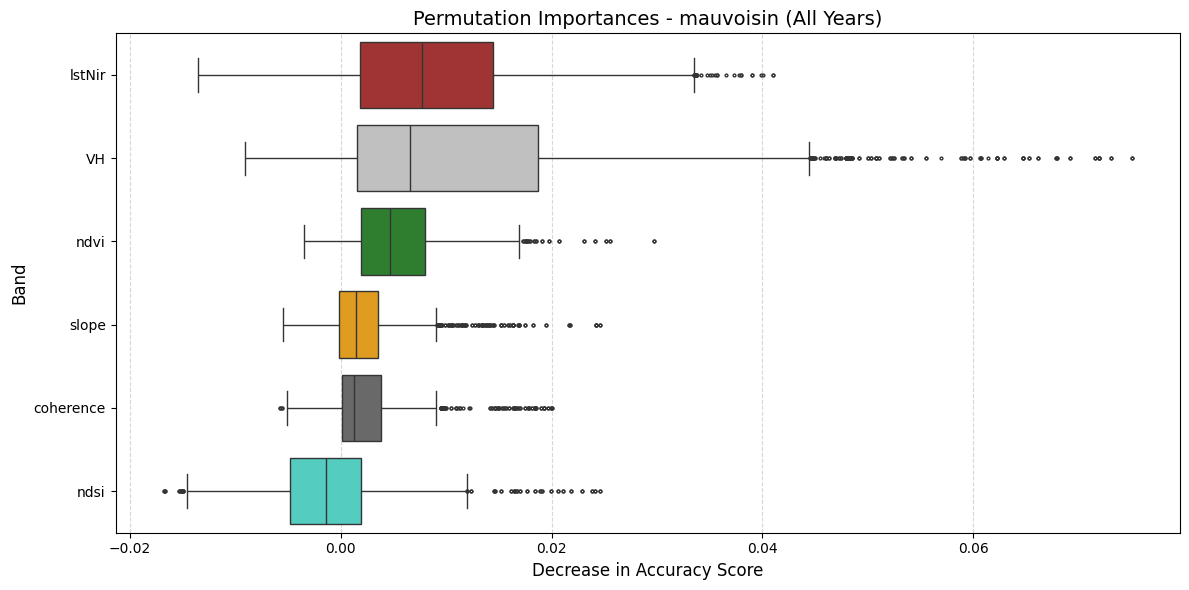

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


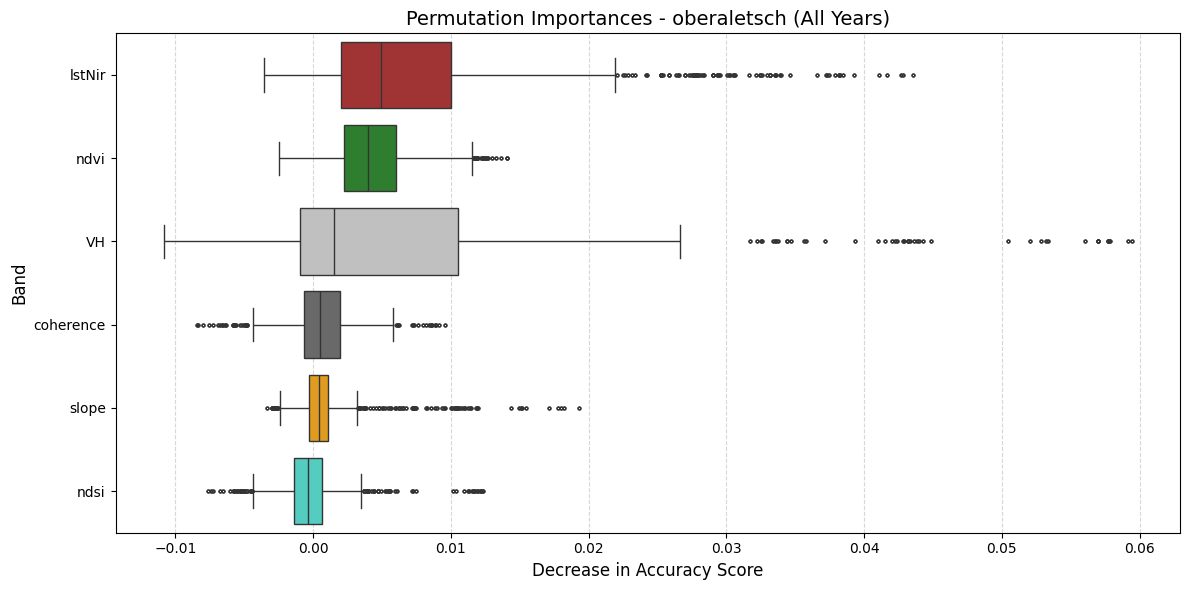

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


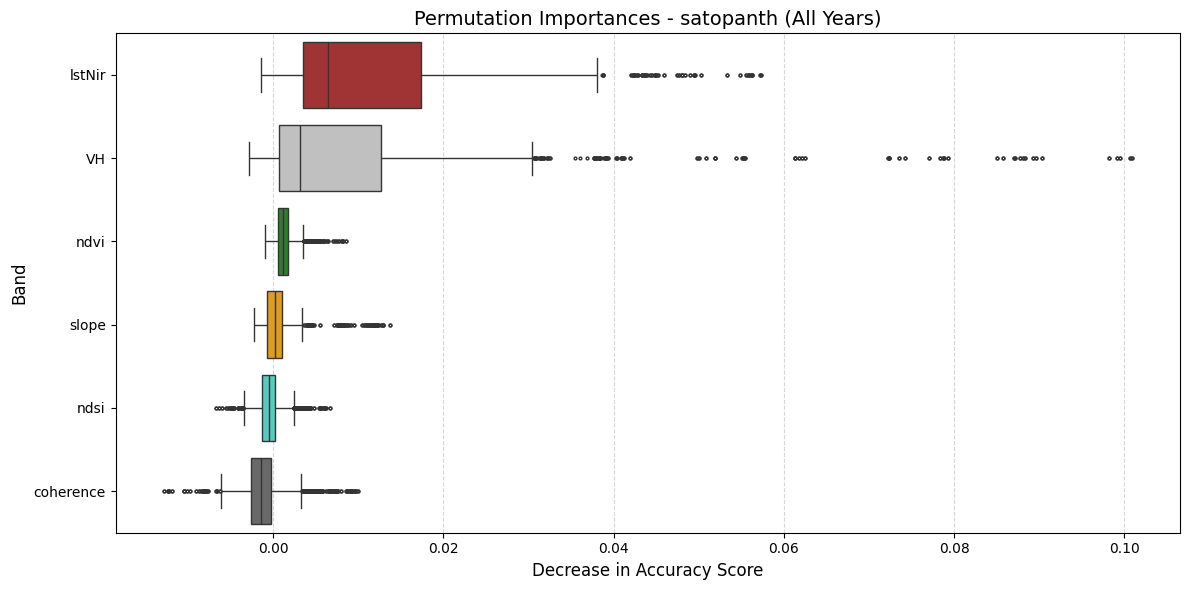

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


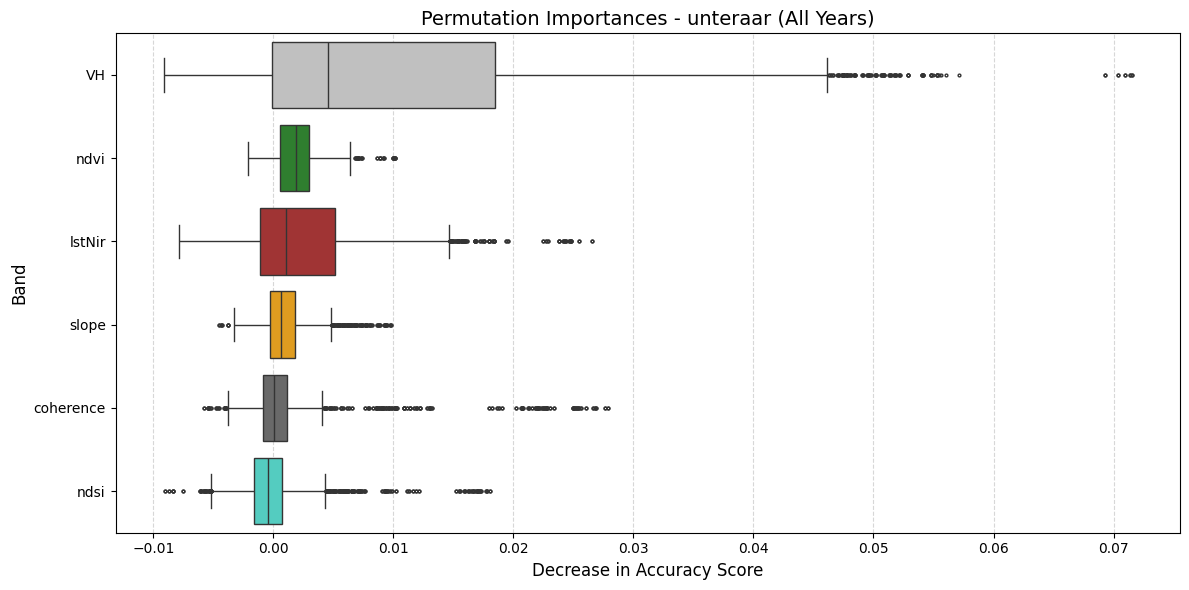

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


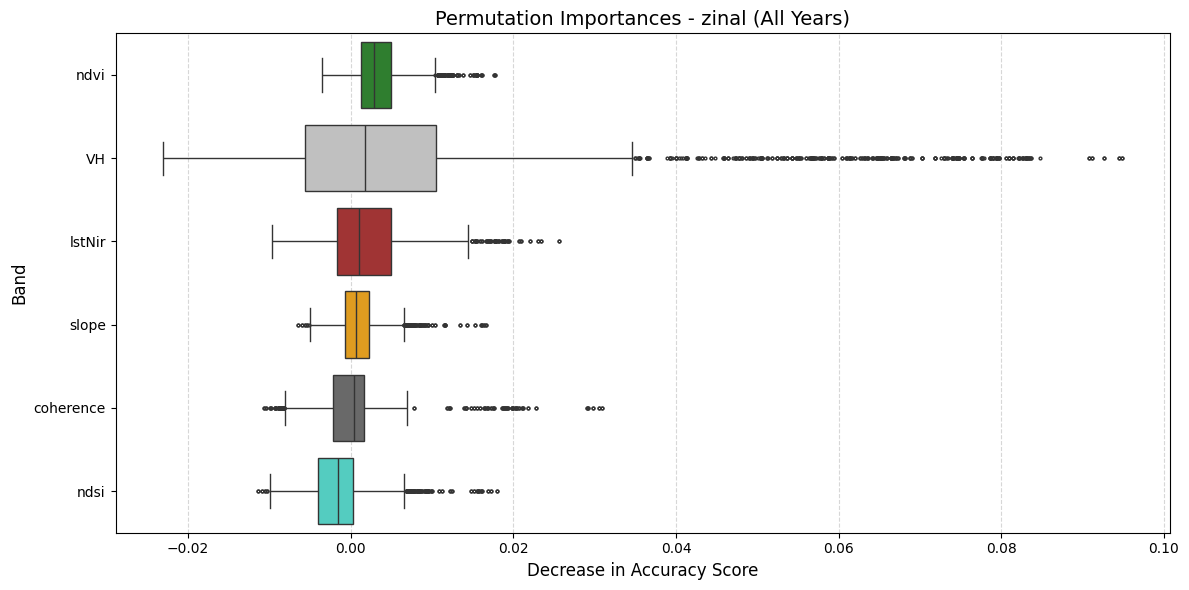

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


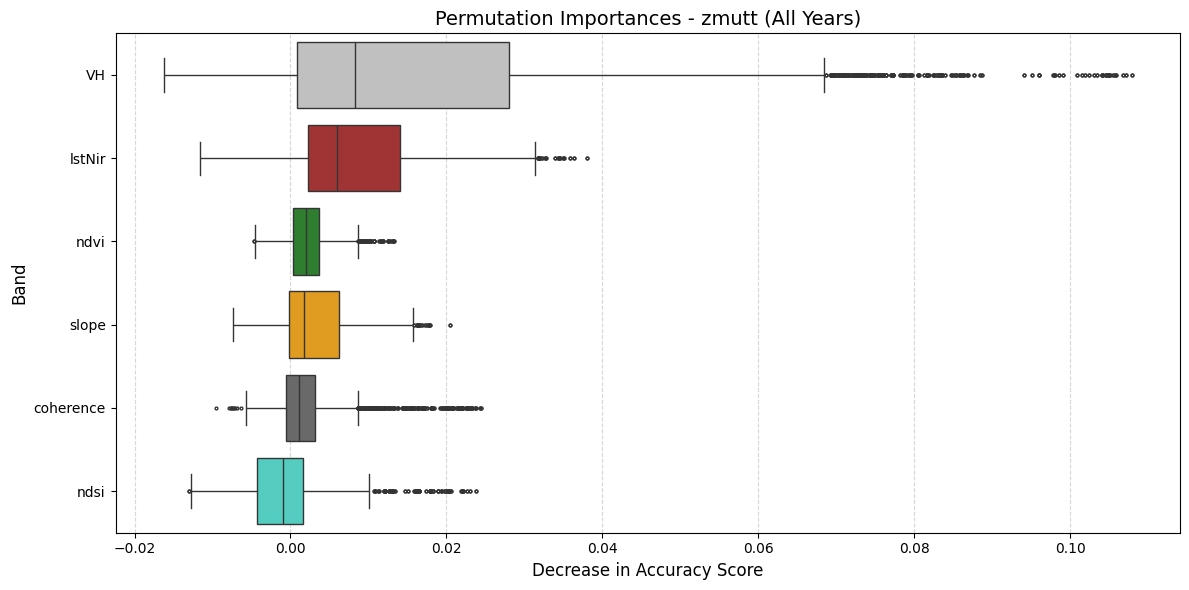

/tmp/ipython-input-137-2898086893.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


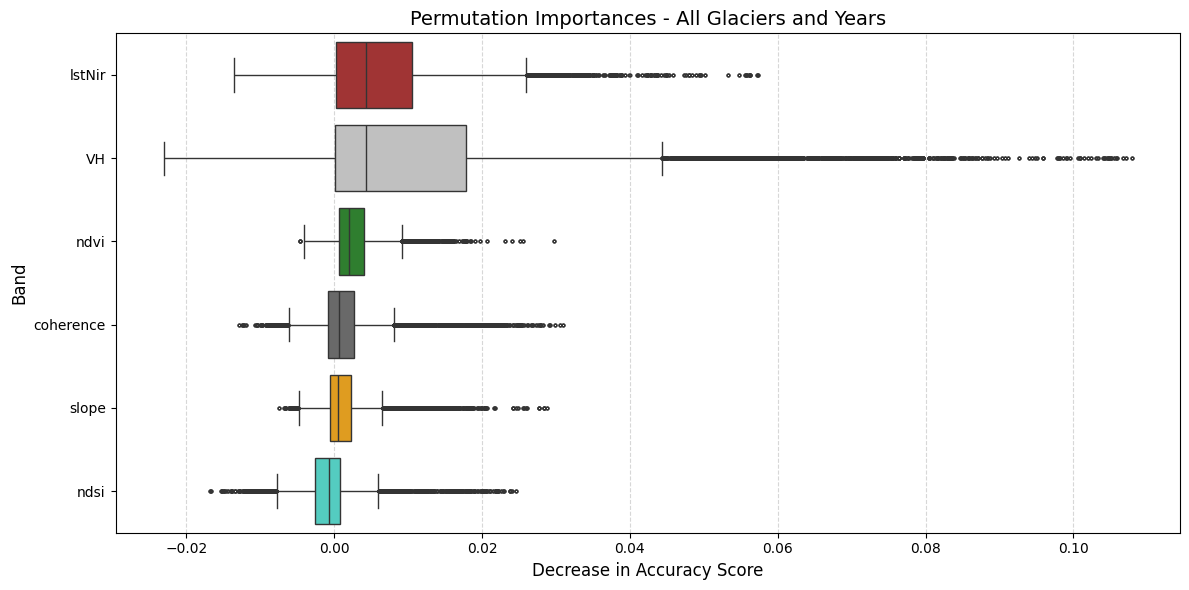

All plots saved to: /content/drive/MyDrive/permutation_importances/plots


In [137]:
# === Config ===
suffixes = ['center', 'top', 'bottom', 'left', 'right']

# Fixed color palette for consistent band coloring
band_colors = {
    'ndwi': 'steelblue',
    'ndvi': 'forestgreen',
    'ndsi': 'turquoise',
    'slope': 'orange',
    'lstNir': 'firebrick',
    'normalizedLst': 'firebrick',
    'coherence': 'dimgray',
    'VH': 'silver'
}

csv_dir = "/content/drive/MyDrive/permutation_importances"
save_dir = os.path.join(csv_dir, "plots")
os.makedirs(save_dir, exist_ok=True)

# === Load and combine CSVs ===
all_data = []

for csv_file in glob.glob(os.path.join(csv_dir, "*_permutation_importances.csv")):
    filename = os.path.basename(csv_file)
    parts = filename.split("_")
    glacier = parts[0]
    year = int(parts[1])

    df = pd.read_csv(csv_file)
    df["Glacier"] = glacier
    df["Year"] = year
    df["BaseBand"] = df["Band"].apply(lambda x: x.split("_")[0])

    all_data.append(df)

all_data = pd.concat(all_data, ignore_index=True)

# === Plotting setup ===
def plot_importance(data, title, save_name):
    # Sort bands by median importance (descending)
    sorted_bands = (
        data.groupby("BaseBand")["Permutation Importance"]
        .median()
        .sort_values(ascending=False)
        .index.tolist()
    )

    # Use fixed palette for consistent coloring
    palette = {band: band_colors.get(band, 'gray') for band in sorted_bands}

    plt.figure(figsize=(12, 6))
    sns.boxplot(
        data=data,
        y="BaseBand", x="Permutation Importance",
        order=sorted_bands,
        palette=palette,
        orient="h",
        fliersize=2,
        linewidth=1
    )
    plt.title(title, fontsize=14)
    plt.xlabel("Decrease in Accuracy Score", fontsize=12)
    plt.ylabel("Band", fontsize=12)
    plt.grid(True, axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, save_name), dpi=300)
    plt.show()
    plt.close()

# === 1. Per Glacier-Year ===
for (glacier, year), group in all_data.groupby(["Glacier", "Year"]):
    title = f"Permutation Importances (Grouped by Base Band) - {glacier} {year}"
    save_name = f"{glacier}_{year}_importance_boxplot.png"
    plot_importance(group, title, save_name)

# === 2. Per Glacier (All Years Combined) ===
for glacier, group in all_data.groupby("Glacier"):
    title = f"Permutation Importances - {glacier} (All Years)"
    save_name = f"{glacier}_all_years_boxplot.png"
    plot_importance(group, title, save_name)

# === 3. Overall Summary ===
title = "Permutation Importances - All Glaciers and Years"
save_name = "all_glaciers_all_years_boxplot.png"
plot_importance(all_data, title, save_name)

print("All plots saved to:", save_dir)
